In [1]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import normaltest
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport

from IPython.display import clear_output
# !pip3 install -U lazypredict
# !pip3 install -U pandas #Upgrading pandas

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
clear_output()

<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#222222;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'></span>Motorbike Price Prediction</div>
 
# Table of Contents
<a id="toc"></a>
- [1. Introduction](#1)
- [2. Imports](#2)
    - [2.1 Function](#2.1)
        - [2.1.1 Residual Plot](#2.1.1)
        - [2.1.2 Detection Values](#2.1.2)
        - [2.1.3 Visualize 3 plots](#2.1.3)
        - [2.1.4 Visualize categorical feaures](#2.1.4)
        - [2.1.5 Prepocessing](#2.1.5)
        - [2.1.6 Feature selection(VIF and P-values)](#2.1.6)
        - [2.1.7 Model Checking](#2.1.7)
- [3. Exploring The Dataset](#3) 
    - [3.1 Load The Datset](#3.1)
    - [3.2 Data Description](#3.2)
    - [3.3 Data Cleaning](#3.3) 
        - [3.3.1 Missing Value](#3.3.1)
        - [3.3.2 Duplicated](#3.3.2)
- [4. Exploratory Data Anlysis(EDA)](#4)
    - [4.1 Target varrible analysis(price)](#4.1)
    - [4.2 Data Visualization ](#4.2)
        - [4.2.1 Numerical variables ](#4.2.1)
        - [4.2.2 Discrete Variable ](#4.2.2)
        - [4.2.3 Category Variable  ](#4.2.3)
        - [4.2.4 Correlatio](#4.2.4)
- [5. Data Pre-Processing](#5)    
    - [5.1 Handling outlier](#5.2)
    - [5.2 Feature Selection and Importance](#5.1)
- [6. Modeling](#6)
    - [6.1 Linear Regression](#6.1)
    - [6.2 Ridge Regression](#6.2)
    - [6.3 Lasso Regression](#6.3)
    - [6.4 Polynomail Regression](#6.4)
    - [6.5 Semi supervised Learning](#6.4)
        - [6.5 K mean++](#6.3)
        - [6.6 Decission Tree Regression](#6.4)
        - [6.7 Fandom Forest Regression](#6.4)
    
- [7. Conclution](#7)   

In [2]:
from scipy.stats import shapiro
def residual_plot(X_train, X_test, y_train, y_test, lm):
    from scipy.stats import shapiro
    
    lm.fit(X_train, y_train)
    y_test_pred = lm.predict(X_test)
    residuals = y_test - y_test_pred
    
#     # normality test
#     stat, p = normaltest(residuals)
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret results
#     alpha = 0.05
#     if p > alpha:
#         print('Sample looks Gaussian (fail to reject H0)')
#     else:
#         print('Sample does not look Gaussian (reject H0)')
        
        
    # normality test
    stat, p = shapiro(residuals)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret results
    alpha = 0.05
    if p > alpha:
        print('Residual looks Gaussian (fail to reject H0)')
    else:
        print('Residual does not look Gaussian (reject H0)')
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    sns.distplot(residuals, bins=20)
    plt.title('Distribution of Residuals')
    plt.xlabel('Errors')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, y_test_pred, label="Predicted vs Actual")
    plt.plot(y_test, y_test, 'r', label="Perfect Prediction")
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual prices')
    plt.ylabel('Predicted prices')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    

    sm.qqplot(residuals, line='s')
    plt.title('QQ Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
    plt.show()

In [3]:
# func to Interquartile Range Method
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [4]:
def outlier_detection(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1
    upper_end = Q3+1.5*IQR
    lower_end = Q1 - 1.5*IQR
    outlier = df[(df>upper_end) | (df<lower_end)]
    return outlier

In [5]:
def visulize_outlier(df, col):
    out_iqr(df, col)
    plt.figure(figsize = (10,6))
    sns.distplot(df[col], kde=False)
    plt.axvspan(xmin = lower,xmax= df[col].min(),alpha=0.2, color='red')
    plt.axvspan(xmin = upper,xmax= df[col].max(),alpha=0.2, color='red')
    plt.show()

<a id="3"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#222222;
            overflow:hidden;
            font-weight:700">3 <span style='color:#CDA63A'>|</span>Exploring The Dataset</div>
<a id="3.1"></a>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <b>3.1 <span style='color:#00008B'>Load The dataset</span></b>

In [6]:
df = pd.read_csv("motorbile_good.csv")

In [7]:
df.shape

(1526, 16)

<a id="3.2"></a>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <b>3.2 <span style='color:#00008B'>Data Description</span></b>

In [8]:
len(df.columns)

16

In [9]:
df.columns

Index(['locations ', 'model', 'year', 'tax type', 'condition', 'color',
       'price', 'fuel_type', 'transmission', 'cylinders',
       'engine_displacement', 'fuel_injection', 'fuel_tank_capacity',
       'maximum_power', 'maximum_torque', 'kl'],
      dtype='object')

* Ad ID : Number of unique IDs for each car.
* Category : The title for promote the motobike (Motorcycles for Sale)
* Locations : The location of please sell Motorcycles(Phnom Penh,Siem Reap,Kandal,Preah Sihanouk  )
* Posted : The date post sell Motorcycles
* Brand : company (Honda)
* Model : The Model of motorbike(Scoopy i ,Dream,PCX )
* Year: The model build in company
* Tax Type: The tax for goverment (Plate Number,Tax Paper )
* Conditio:The motorbike will use ot not use(Used ,New)
* Color:The color of motobike (Black,White,Red,Blue...)
* Link : Link to connection to dataset
* Title : The tamplate for posting
* Price:Total price of car in dollars

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   locations            1526 non-null   object 
 1   model                1526 non-null   object 
 2   year                 1526 non-null   int64  
 3   tax type             1526 non-null   int64  
 4   condition            1526 non-null   int64  
 5   color                1526 non-null   object 
 6   price                1526 non-null   float64
 7   fuel_type            1526 non-null   object 
 8   transmission         1526 non-null   object 
 9   cylinders            1526 non-null   int64  
 10  engine_displacement  1526 non-null   float64
 11  fuel_injection       1526 non-null   object 
 12  fuel_tank_capacity   1526 non-null   float64
 13  maximum_power        1526 non-null   float64
 14  maximum_torque       1526 non-null   float64
 15  kl                   1526 non-null   f

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Car Price Prediction:</u></b><br>

* Locations : The location of please sell Motorcycles(Phnom Penh,Siem Reap,Kandal,Preah Sihanouk  )
* Model : The Model of motorbike(Scoopy i ,Dream,PCX )
* Year: The model build in company
* Tax Type: The tax for goverment (Plate Number,Tax Paper )
* Conditio:The motorbike will use ot not use(Used ,New)
* Color:The color of motobike (Black,White,Red,Blue...)
* Price:Total price of car in dollars
* fuel_type : Gasoline
* transmission : system of motorbike(Auto , Manual)
* cylinders : (1,2) cylinders
* engine_displacement : th power mortorbike
* fuel_injection : accuracy
* fuel_tank_capacity 
* maximum_power
* K / L : petroll
</div>

In [11]:
# find group top 5 all feature 
for col in df.columns:
    print( col,':', df[col].nunique() )
    print(df[col].value_counts().nlargest(5))
    print('\n' + '*' * 20 + '\n')

locations  : 21
phnom penh          1307
siem reap             81
kandal                36
preah sihanouk        20
banteay meanchey      13
Name: locations , dtype: int64

********************

model : 10
scoopy i    387
dream       267
pcx         267
click       183
zoomer-x    136
Name: model, dtype: int64

********************

year : 10
2    242
3    175
5    174
7    166
4    166
Name: year, dtype: int64

********************

tax type : 2
0    1363
1     163
Name: tax type, dtype: int64

********************

condition : 1
1    1526
Name: condition, dtype: int64

********************

color : 14
white    584
black    473
red      216
blue      95
other     54
Name: color, dtype: int64

********************

price : 380
850.0000     40
1750.0000    28
800.0000     25
1050.0000    25
950.0000     25
Name: price, dtype: int64

********************

fuel_type : 1
Gasoline    1526
Name: fuel_type, dtype: int64

********************

transmission : 2
Auto      1119
Manual     407
Nam

In [12]:
# describe the data
df.describe(percentiles=[.10, .25, .50, .75, .90, .99])

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl
count,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000,1526.0000
mean,4.8460,0.1068,1.0000,1560.9325,1.0295,122.9867,5.9291,13.0668,11.7441,49.0734
std,2.6467,0.3090,0.0000,770.2049,0.1692,19.2874,2.2471,19.7197,10.9372,8.8180
min,1.0000,0.0000,1.0000,111.0000,1.0000,108.2000,3.7000,7.4000,6.8000,13.0000
10%,2.0000,0.0000,1.0000,750.0000,1.0000,110.0000,3.7000,7.8000,8.2000,41.0000
25%,2.0000,0.0000,1.0000,980.0000,1.0000,110.0000,3.7000,8.0000,8.5000,44.0000
50%,5.0000,0.0000,1.0000,1480.0000,1.0000,110.0000,5.5000,8.4000,8.8000,49.0000
75%,7.0000,0.0000,1.0000,1889.5000,1.0000,125.0000,8.0000,9.1000,10.3000,56.0000
90%,9.0000,1.0000,1.0000,2450.0000,1.0000,157.0000,8.0000,15.4000,14.6000,60.0000
99%,10.0000,1.0000,1.0000,3929.2500,2.0000,160.0000,13.0000,125.0000,73.0000,63.7000


In [13]:
# find group top 5 all feature 
for col in df.columns:
    print( col,':', df[col].nunique() )
    print(df[col].value_counts().nlargest(5))
    print('\n' + '*' * 20 + '\n')

locations  : 21
phnom penh          1307
siem reap             81
kandal                36
preah sihanouk        20
banteay meanchey      13
Name: locations , dtype: int64

********************

model : 10
scoopy i    387
dream       267
pcx         267
click       183
zoomer-x    136
Name: model, dtype: int64

********************

year : 10
2    242
3    175
5    174
7    166
4    166
Name: year, dtype: int64

********************

tax type : 2
0    1363
1     163
Name: tax type, dtype: int64

********************

condition : 1
1    1526
Name: condition, dtype: int64

********************

color : 14
white    584
black    473
red      216
blue      95
other     54
Name: color, dtype: int64

********************

price : 380
850.0000     40
1750.0000    28
800.0000     25
1050.0000    25
950.0000     25
Name: price, dtype: int64

********************

fuel_type : 1
Gasoline    1526
Name: fuel_type, dtype: int64

********************

transmission : 2
Auto      1119
Manual     407
Nam

<a id="3.3"></a>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <b>3.3 <span style='color:#00008B'>Data Cleaning</span></b>

In [14]:
df['model'].unique()

array(['scoopy i', 'dream', 'pcx', 'click', 'zoomer-x', 'beat',
       'msx grom', 'cbr', 'adv', 'wave'], dtype=object)

In [15]:
df.columns = df.columns.str.lower()
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
print(string_columns)
for col in string_columns:
    df[col] = df[col].str.lower()

['locations ', 'model', 'color', 'fuel_type', 'transmission', 'fuel_injection']


In [16]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl
count,"1,526.00","1,526.00","1,526.00","1,526.00","1,526.00","1,526.00","1,526.00","1,526.00","1,526.00","1,526.00"
mean,4.85,0.11,1.00,"1,560.93",1.03,122.99,5.93,13.07,11.74,49.07
std,2.65,0.31,0.00,770.20,0.17,19.29,2.25,19.72,10.94,8.82
min,1.00,0.00,1.00,111.00,1.00,108.20,3.70,7.40,6.80,13.00
25%,2.00,0.00,1.00,980.00,1.00,110.00,3.70,8.00,8.50,44.00
50%,5.00,0.00,1.00,"1,480.00",1.00,110.00,5.50,8.40,8.80,49.00
75%,7.00,0.00,1.00,"1,889.50",1.00,125.00,8.00,9.10,10.30,56.00
max,10.00,1.00,1.00,"4,300.00",2.00,160.00,13.00,125.00,73.00,63.70


In [17]:
df.describe(include=['O'])

,locations,model,color,fuel_type,transmission,fuel_injection
count,1526,1526,1526,1526,1526,1526
unique,21,10,14,1,2,2
top,phnom penh,scoopy i,white,gasoline,auto,yes
freq,1307,387,584,1526,1119,1481


<a id="3.3.1"></a>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>
    
## <b>3.3.1 <span style='color:#00008B'> Check missing values </span></b>

In [18]:
df.isnull().sum()

locations              0
model                  0
year                   0
tax type               0
condition              0
color                  0
price                  0
fuel_type              0
transmission           0
cylinders              0
engine_displacement    0
fuel_injection         0
fuel_tank_capacity     0
maximum_power          0
maximum_torque         0
kl                     0
dtype: int64

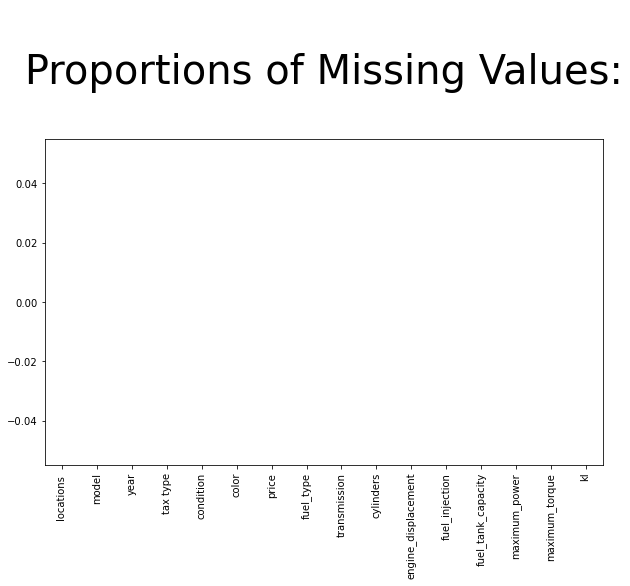

In [19]:
d=((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)
d.plot(kind='bar',
color=sns.cubehelix_palette(start=2, rot=0.3, dark=0.15, light=0.9, reverse=True, n_colors=24),
figsize=(10,6))
plt.title("\nProportions of Missing Values:\n",fontsize=40)
plt.show()

In [20]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() >= 1]
features_with_na

[]

In [21]:
#dataset['Electrical'].isnull().mean()
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean(),4),'%missing values')

In [22]:
#dataset['Electrical'].isnull().mean()
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean(),4),'%missing values')

---

![Image](https://www.simplypsychology.org/wp-content/uploads/bloxplots-skewed.jpg)

---

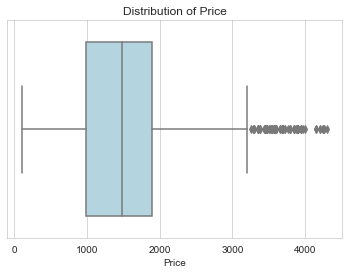

In [23]:
import seaborn as sns
color_palette = ['lightblue']
sns.set_style("whitegrid")
sns.boxplot(data=df, x='price', color=color_palette[0])
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.show()

In [24]:
data = df.copy()
for feature in features_with_na:
    # Create a variable that indicates 1 if the observation was missing or 0 otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # Calculate the mean SalePrice where the information is missing or present
    median_price = data.groupby(feature)['price'].median()
    median_price.plot.bar(color=['skyblue', 'lightcoral'])
    
    plt.title(feature)
    plt.show()


In [25]:
df.dropna(inplace=True)

<blockquote style="background-color: lightcoral; padding: 10px;">
Here With the relation between the missing values and dependent variable is clearly.  
So we need theses nan values with something meaninful with we will do in Feature Engineering section  
</blockquote>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>
<a id="1.2"></a>

<a id="3.3.2"></a>
## <b>3.3.2 <span style='color:#00008B'> Duplicated </span></b>

In [26]:
df.duplicated().sum()

0

In [27]:
df.drop_duplicates(inplace=True)

<blockquote style="background-color: lightcoral; padding: 10px;">
The Dataset have some duplicated more dumplicated
</blockquote>

In [28]:
df['locations '].value_counts()

phnom penh          1307
siem reap             81
kandal                36
preah sihanouk        20
banteay meanchey      13
kampong cham          11
kampong speu           9
prey veng              9
battambang             8
takeo                  7
kampong chhnang        4
kampot                 4
kampong thom           3
svay rieng             3
koh kong               3
tboung khmum           2
pursat                 2
preah vihear           1
pailin                 1
oddar meanchey         1
stung treng            1
Name: locations , dtype: int64

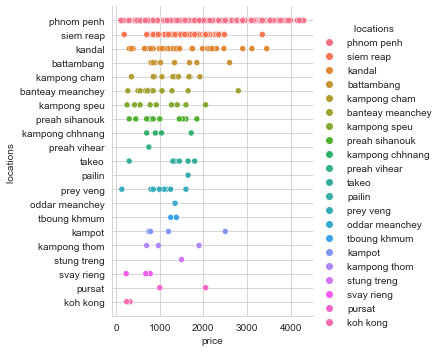

In [29]:
sns.relplot(x = 'price', y = 'locations ', data=df, hue='locations ');

In [30]:
df.shape 

(1526, 16)

In [31]:
pf = ProfileReport(df) 

In [32]:
pf.to_widgets() 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
df['model'].value_counts()

scoopy i    387
dream       267
pcx         267
click       183
zoomer-x    136
beat        101
msx grom     50
cbr          45
adv          45
wave         45
Name: model, dtype: int64

<blockquote style="background-color: lightblue; padding: 10px;">
The Data are Error in Data set wrapping
</blockquote>



In [34]:
df.loc[(df['model'] == "scoopy i")]

,locations,model,year,tax type,condition,color,price,fuel_type,transmission,cylinders,engine_displacement,fuel_injection,fuel_tank_capacity,maximum_power,maximum_torque,kl
0,phnom penh,scoopy i,8,0,1,white,680.00,gasoline,auto,1,110.00,yes,3.70,8.00,8.20,46.00
1,phnom penh,scoopy i,9,0,1,black,990.00,gasoline,auto,1,110.00,yes,3.70,7.90,8.10,44.00
2,phnom penh,scoopy i,8,0,1,red,950.00,gasoline,auto,1,110.00,yes,3.70,8.00,8.20,46.00
3,phnom penh,scoopy i,2,0,1,black,"1,680.00",gasoline,auto,1,110.00,yes,3.70,8.60,8.80,58.00
4,phnom penh,scoopy i,3,0,1,black,"1,790.00",gasoline,auto,1,110.00,yes,3.70,8.50,8.70,56.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,phnom penh,scoopy i,5,1,1,white,111.00,gasoline,auto,1,110.00,yes,3.70,8.30,8.50,52.00
383,phnom penh,scoopy i,7,0,1,black,850.00,gasoline,auto,1,110.00,yes,3.70,8.10,8.30,48.00
384,siem reap,scoopy i,3,0,1,white,"1,750.00",gasoline,auto,1,110.00,yes,3.70,8.50,8.70,56.00
385,phnom penh,scoopy i,7,0,1,white,750.00,gasoline,auto,1,110.00,yes,3.70,8.10,8.30,48.00


In [35]:
count = (df["year"] == -1).sum()
print("Count:", count)
df.loc[df["year"] == -1].head()

Count: 0


,locations,model,year,tax type,condition,color,price,fuel_type,transmission,cylinders,engine_displacement,fuel_injection,fuel_tank_capacity,maximum_power,maximum_torque,kl


In [36]:
count = (df["year"] == 0).sum()
print("Count:", count)
df.loc[df["year"] == 0].head()

Count: 0


,locations,model,year,tax type,condition,color,price,fuel_type,transmission,cylinders,engine_displacement,fuel_injection,fuel_tank_capacity,maximum_power,maximum_torque,kl


In [37]:
(df.loc[df['model'] == 'scoopy i']).groupby('year').agg(lambda tdf: tdf.unique().tolist())

,locations,model,tax type,condition,color,price,fuel_type,transmission,cylinders,engine_displacement,fuel_injection,fuel_tank_capacity,maximum_power,maximum_torque,kl
year,,,,,,,,,,,,,,,
1,"[phnom penh, siem reap, preah sihanouk]",[scoopy i],"[0, 1]",[1],"[blue, white, black, gray, red, green, beige, ...","[2180.0, 2190.0, 2250.0, 1250.0, 2080.0, 2299....",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.7],[8.9],[60.0]
2,"[phnom penh, siem reap, kampong cham, kandal]",[scoopy i],"[0, 1]",[1],"[black, red, white, gray, blue, beige]","[1680.0, 1962.0, 2030.0, 1699.0, 1750.0, 1580....",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.6],[8.8],[58.0]
3,"[phnom penh, battambang, kampong speu, siem reap]",[scoopy i],"[0, 1]",[1],"[black, white, other, blue, red, green, brown]","[1790.0, 1800.0, 1700.0, 1830.0, 1550.0, 1670....",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.5],[8.7],[56.0]
4,"[phnom penh, siem reap]",[scoopy i],"[0, 1]",[1],"[white, red, black, gray, blue]","[1560.0, 1530.0, 1548.4, 1650.0, 1595.0, 1550....",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.4],[8.6],[54.0]
5,"[phnom penh, kandal]",[scoopy i],"[0, 1]",[1],"[white, gray, green, silver, red, blue, orange...","[300.0, 1568.0, 1470.0, 1499.0, 1050.0, 1620.0...",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.3],[8.5],[52.0]
6,[phnom penh],[scoopy i],[0],[1],"[silver, red, white, gold, black]","[300.0, 1100.0, 480.0, 850.0, 800.0]",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.2],[8.4],[50.0]
7,"[phnom penh, kandal, siem reap, kampong chhnang]",[scoopy i],"[0, 1]",[1],"[red, white, black, other, gold, beige]","[1040.0, 810.0, 980.0, 1030.0, 800.0, 1150.0, ...",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.1],[8.3],[48.0]
8,"[phnom penh, banteay meanchey, siem reap]",[scoopy i],"[0, 1]",[1],"[white, red, gray, other, black, yellow, blue]","[680.0, 950.0, 970.0, 980.0, 1100.0, 1080.0, 1...",[gasoline],[auto],[1],[110.0],[yes],[3.7],[8.0],[8.2],[46.0]
9,"[phnom penh, kandal, banteay meanchey, siem re...",[scoopy i],"[0, 1]",[1],"[black, white, red, orange, other, yellow]","[990.0, 920.0, 860.0, 780.0, 700.0, 1050.0, 98...",[gasoline],[auto],[1],[110.0],[yes],[3.7],[7.9],[8.1],[44.0]


In [38]:
df['year'].value_counts()

2     242
3     175
5     174
7     166
4     166
1     152
8     150
6     146
9      88
10     67
Name: year, dtype: int64

In [39]:
df['fuel_injection'].value_counts()

yes    1481
no       45
Name: fuel_injection, dtype: int64

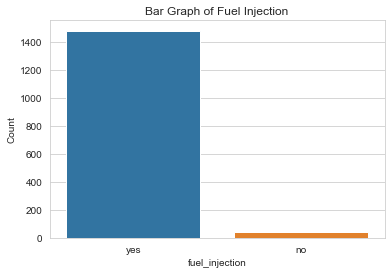

In [40]:
condition_counts = df['fuel_injection'].value_counts()
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.xlabel('fuel_injection')
plt.ylabel('Count')
plt.title('Bar Graph of Fuel Injection')
plt.show()

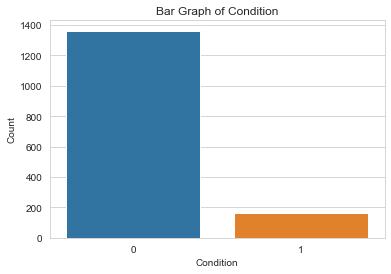

In [41]:
condition_counts = df['tax type'].value_counts()
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Bar Graph of Condition')
plt.show()

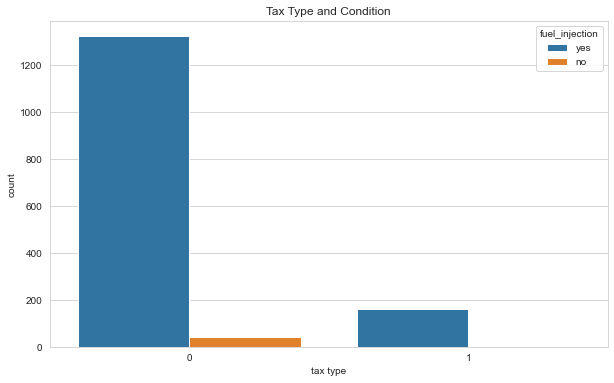

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tax type', hue='fuel_injection')
plt.title('Tax Type and Condition')
plt.show()

In [43]:
# ## use Labelconding
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()

# df['fuel_injection']=LE.fit_transform(df['fuel_injection'])

In [44]:
df['fuel_injection'].value_counts()

yes    1481
no       45
Name: fuel_injection, dtype: int64

In [45]:
# ## use Labelconding
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()

# df['fuel_injection']=LE.fit_transform(df['fuel_injection'])
# ## use Labelconding
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()

# df['transmission']=LE.fit_transform(df['transmission'])

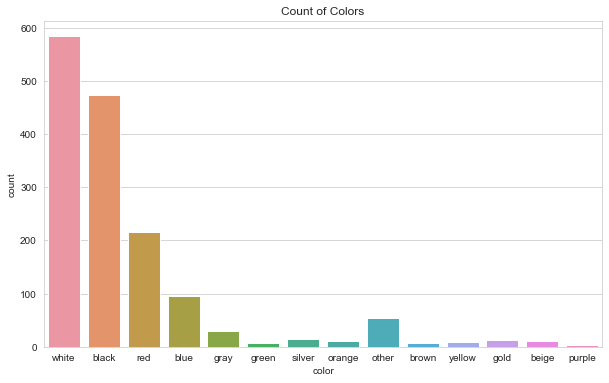

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='color')
plt.title('Count of Colors')
plt.show() 

In [47]:
labels = ["0-2", "2-4", "4-6", "6-8","8-10"]
bins = [0,2,4,6,8,10]
freq_df = df.groupby(pd.cut(df['year'], bins=bins, labels=labels)).size()

In [48]:
freq_df

year
0-2     394
2-4     341
4-6     320
6-8     316
8-10    155
dtype: int64

In [49]:
freq_df = freq_df.reset_index(name='count')

In [50]:
freq_df

,year,count
0,0-2,394
1,2-4,341
2,4-6,320
3,6-8,316
4,8-10,155


<AxesSubplot:>

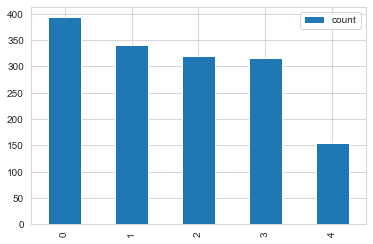

In [51]:
freq_df.plot(kind='bar')

<AxesSubplot:>

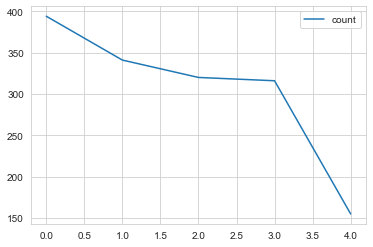

In [52]:
freq_df.plot(kind='line')

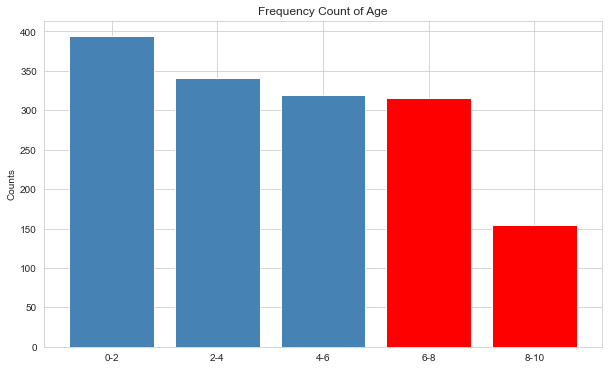

In [53]:

# Create a list of colors
colors = ['steelblue'] * len(freq_df['year'])  
colors[3] = 'red'  
colors[4] = 'red'
# Plot the bar graph with customized colors
plt.figure(figsize=(10, 6))
plt.bar(freq_df['year'], freq_df['count'], color=colors)
plt.ylabel('Counts')
plt.title('Frequency Count of Age')
plt.show()



## * Narative

<blockquote style="background-color: lightblue; padding: 10px;">
Highest prevalence of Hepatitis is from 2001-2011 followed by 2017 motorbike
</blockquote>

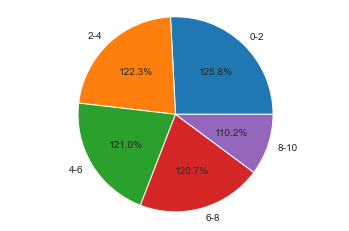

In [54]:
# Pie chart
labels = ["0-2", "2-4", "4-6", "6-8","8-10"]
fig1, ax1 = plt.subplots()
ax1.pie(freq_df["count"], labels=labels, autopct='1%.1f%%')
ax1.axis('equal')
plt.show()

<a id="4"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#222222;
            overflow:hidden;
            font-weight:700">2 <span style='color:#CDA63A'>|</span> Exploratory Data Anlysis(EDA)</div>
<a id="1.1"></a>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.1"></a>
## <b>4.1 <span style='color:#00008B'>Target variable analysis (price)</span></b>

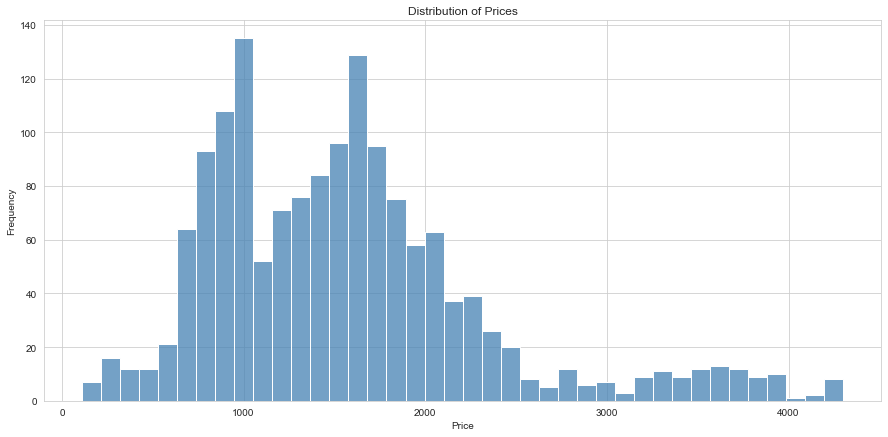

In [55]:
plt.figure(figsize=(15, 7))
sns.histplot(df.price, bins=40, color='steelblue')
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of Prices')
plt.show()


<blockquote style="background-color: lightcoral; padding: 10px;">
This is a long tail distribution, which is a typical situation for many items with low prices and very few expensive between 0 or 5000.We can have a closer look by zooming in a bit and looking at values below 1000
</blockquote>

---

![Image](https://www.learnbyexample.org/wp-content/uploads/r/typical-quantile-quantile-qq-plot.png)

--- 
<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Technique</u></b><br>
 
The target of labels is not normal destruction .it mean that the data will not have strong correctionship with any features .
</div>

<h3 style="color:red">Log Transformation</h3>

In [56]:
# df['log_price'] = np.log1p(df.price)

# plt.figure(figsize=(6, 4))

# sns.histplot(df.log_price, bins=40)
# plt.ylabel('Frequency')
# plt.xlabel('Log(Price + 1)')
# plt.title('Distribution of prices after log tranformation')

# plt.show()

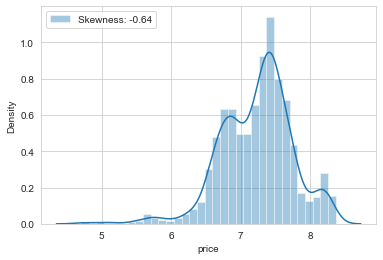

In [57]:
Log_Ave = df["price"].map(lambda i: np.log(i) if i > 0 else 0)
t = sns.distplot(Log_Ave,label="Skewness: %.2f"%(Log_Ave.skew()) )
t.legend()

In [58]:
#df = df.drop(['log_price'], axis = 1)

In [59]:
pd.DataFrame(df['price'].agg(['min', 'mean', 'median','max','std', 'skew'])).T

,min,mean,median,max,std,skew
price,111.00,"1,560.93","1,480.00","4,300.00",770.20,1.15


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Guideline</u></b><br>
 
* What is the effect feature that make poteseil for price motorbike ?.

* What is the best model that make good profile for company ?

* If We want to change Motorbike, How much it cost ? 
</div>

<a id="4.2"></a>

## <b>4.2 <span style='color:#00008B'>Data Visualization</span></b>
<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.2.1"></a>
## <b>4.2.1 <span style='color:#00008B'>Numerical variables</span></b>

In [60]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != "O"]

In [61]:
print(len(numerical_features))
df[numerical_features].head()

10


,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl
0,8,0,1,680.00,1,110.00,3.70,8.00,8.20,46.00
1,9,0,1,990.00,1,110.00,3.70,7.90,8.10,44.00
2,8,0,1,950.00,1,110.00,3.70,8.00,8.20,46.00
3,2,0,1,"1,680.00",1,110.00,3.70,8.60,8.80,58.00
4,3,0,1,"1,790.00",1,110.00,3.70,8.50,8.70,56.00


<h3 style="color:red"> Temporal Variable(Eg: DateTime Variable)<h3>

In [62]:
# Temporal Variable(Eg: DateTime Variable)
year_fearure = [feature for feature in numerical_features if 'year' in feature or 'Year' in feature]
year_fearure

['year']

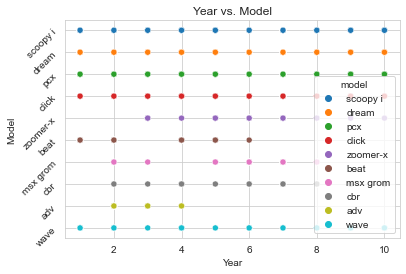

In [63]:
sns.set_style("whitegrid")
sns.scatterplot(data=df, x='year', y='model', hue='model')
plt.title('Year vs. Model')
plt.xlabel('Year')
plt.ylabel('Model')
plt.yticks(rotation=45)
plt.show()

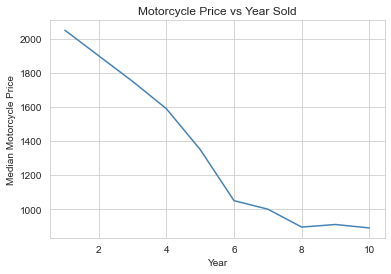

In [64]:
data.groupby('year')['price'].median().plot(color='steelblue')
plt.xlabel('Year')
plt.ylabel('Median Motorcycle Price')
plt.title('Motorcycle Price vs Year Sold')
plt.show()

<blockquote style="background-color: lightcoral; padding: 10px;">
By Visualisation with year and price the daily life we know that the motorbike will be decreasing propersional with life time 
</blockquote>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.2.2"></a>
## <b>4.2.2 <span style='color:#00008B'>Discrete Variable</span></b>

In [65]:
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<=6]
df[discrete_features].head()

,tax type,condition,cylinders,engine_displacement
0,0,1,1,110.00
1,0,1,1,110.00
2,0,1,1,110.00
3,0,1,1,110.00
4,0,1,1,110.00


In [66]:
# Continous Variable
continous_features = [feature for feature in numerical_features if feature not in discrete_features]
print(len(continous_features))
df[continous_features].head()

6


,year,price,fuel_tank_capacity,maximum_power,maximum_torque,kl
0,8,680.00,3.70,8.00,8.20,46.00
1,9,990.00,3.70,7.90,8.10,44.00
2,8,950.00,3.70,8.00,8.20,46.00
3,2,"1,680.00",3.70,8.60,8.80,58.00
4,3,"1,790.00",3.70,8.50,8.70,56.00


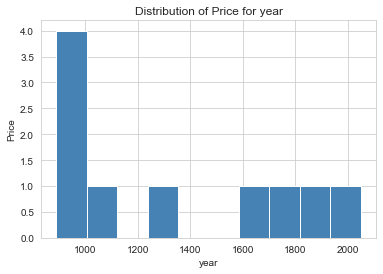

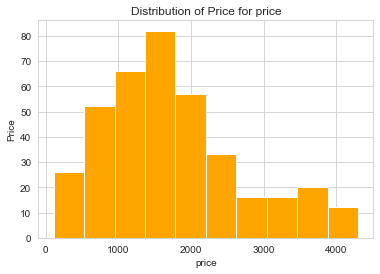

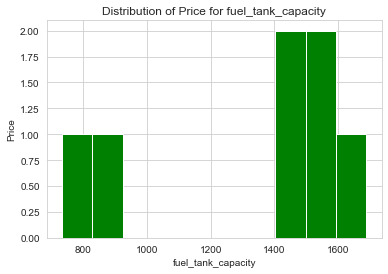

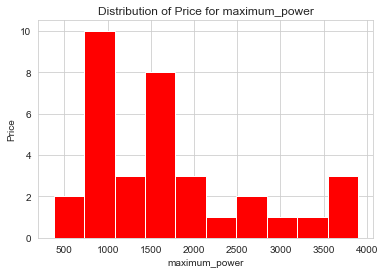

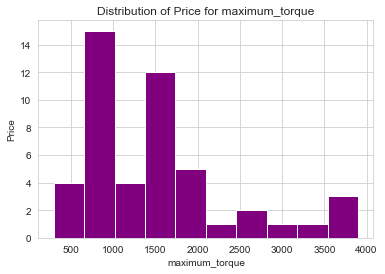

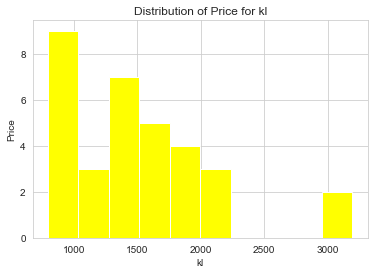

In [67]:
data = df.copy()
colors = ['steelblue', 'orange', 'green', 'red', 'purple', 'yellow']  

for i, feature in enumerate(continous_features):
    data.groupby(feature)['price'].median().plot.hist(color=colors[i % len(colors)])
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(f'Distribution of Price for {feature}')
    plt.show()

<blockquote style="background-color: lightcoral; padding: 10px;">
The technique to find the best correlation we need to drop outlies that will make the weak correlation and drop Error Data
</blockquote>

In [68]:
def check_column_value(df, value):
    """
    Checks if each column in a pandas DataFrame contains a specific value and prints the column names that contain the value.
    
    Parameters:
        df (pandas DataFrame): The DataFrame to check.
        value (any type): The value to look for in each column.
    """
    if type(value) != str:
        values = list(value)
    elif type(value) == list():
        values = value
    else: values = [value]
    matching_columns = df.apply(lambda col: col.isin(values).any())
    matching_columns = matching_columns[matching_columns == True]
    count = {}
    index = set()
    for value in values:
        for col in matching_columns.index.tolist():
            if count == {}:
                count[col] = []
            elif col not in count:
                count[col] = []
            
            count[col].append(df[df[col] == value].loc[:, col].count())
            for i in df[df[col] == value].loc[:, col].index.tolist():
                index.add(i)
  
    print(f"\033[94mColumns that contain the {values}:\n")
    print(pd.Series(count))
    
    return index
    

In [69]:
index = check_column_value(df, ['other', 'other - ផ្សេងៗ'])

Columns that contain the ['other', 'other - ផ្សេងៗ']:

color    [54, 0]
dtype: object


In [70]:
df.drop(index, axis = 'rows', inplace= True)

In [71]:
df.shape

(1472, 16)

In [72]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75) 
IQR = q3 - q1
IQR
### Get the actual datapoint that is an outlier(data < (q1 -1.5 * IQR)) | (data >(q3 + 1.5 * IQR)) 
df_no_outlier = data[~((data < (q1 -1.5 * IQR)) | (data >(q3 + 1.5 * IQR))).any(axis=1)] 
df_no_outlier

,locations,model,year,tax type,condition,color,price,fuel_type,transmission,cylinders,engine_displacement,fuel_injection,fuel_tank_capacity,maximum_power,maximum_torque,kl
0,phnom penh,scoopy i,8,0,1,white,680.00,gasoline,auto,1,110.00,yes,3.70,8.00,8.20,46.00
1,phnom penh,scoopy i,9,0,1,black,990.00,gasoline,auto,1,110.00,yes,3.70,7.90,8.10,44.00
2,phnom penh,scoopy i,8,0,1,red,950.00,gasoline,auto,1,110.00,yes,3.70,8.00,8.20,46.00
3,phnom penh,scoopy i,2,0,1,black,"1,680.00",gasoline,auto,1,110.00,yes,3.70,8.60,8.80,58.00
4,phnom penh,scoopy i,3,0,1,black,"1,790.00",gasoline,auto,1,110.00,yes,3.70,8.50,8.70,56.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,phnom penh,wave,6,0,1,black,670.00,gasoline,manual,1,110.00,yes,4.00,7.80,7.60,45.00
1522,phnom penh,wave,4,0,1,black,111.00,gasoline,manual,1,110.00,yes,4.00,8.00,8.00,49.00
1523,kampong thom,wave,10,0,1,black,700.00,gasoline,manual,1,110.00,yes,4.00,7.40,6.80,37.00
1524,kandal,wave,4,0,1,black,"1,050.00",gasoline,manual,1,110.00,yes,4.00,8.00,8.00,49.00


In [73]:
df_no_outlier.isnull().sum(),df_no_outlier.shape

(locations              0
 model                  0
 year                   0
 tax type               0
 condition              0
 color                  0
 price                  0
 fuel_type              0
 transmission           0
 cylinders              0
 engine_displacement    0
 fuel_injection         0
 fuel_tank_capacity     0
 maximum_power          0
 maximum_torque         0
 kl                     0
 dtype: int64,
 (1074, 16))

<blockquote style="background-color: lightblue; padding: 10px;">
 The model of motorbike have Error Missing value "other - ផ្សេងៗ     96" it mean that don't know prank model
 So it make the model overfities , We will drop it row 
</blockquote>

In [74]:
print(df.shape)
print(df_no_outlier.shape)

(1472, 16)
(1074, 16)


In [75]:
df = df_no_outlier.copy()

In [76]:
df.shape

(1074, 16)

In [77]:
df['model'].value_counts()

scoopy i    350
dream       250
click       171
zoomer-x    127
beat         90
msx grom     43
wave         43
Name: model, dtype: int64

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>
<a id="4.2.3"></a>
## <b> 4.2.3 <span style='color:#00008B'>Category Variable</span></b>

In [78]:
categorical_feature = [feature for feature in df_no_outlier.columns if df_no_outlier[feature].dtype == 'O']
print(df_no_outlier[categorical_feature].columns)
print(len(categorical_feature))
df_no_outlier[categorical_feature]

Index(['locations ', 'model', 'color', 'fuel_type', 'transmission',
       'fuel_injection'],
      dtype='object')
6


,locations,model,color,fuel_type,transmission,fuel_injection
0,phnom penh,scoopy i,white,gasoline,auto,yes
1,phnom penh,scoopy i,black,gasoline,auto,yes
2,phnom penh,scoopy i,red,gasoline,auto,yes
3,phnom penh,scoopy i,black,gasoline,auto,yes
4,phnom penh,scoopy i,black,gasoline,auto,yes
...,...,...,...,...,...,...
1521,phnom penh,wave,black,gasoline,manual,yes
1522,phnom penh,wave,black,gasoline,manual,yes
1523,kampong thom,wave,black,gasoline,manual,yes
1524,kandal,wave,black,gasoline,manual,yes


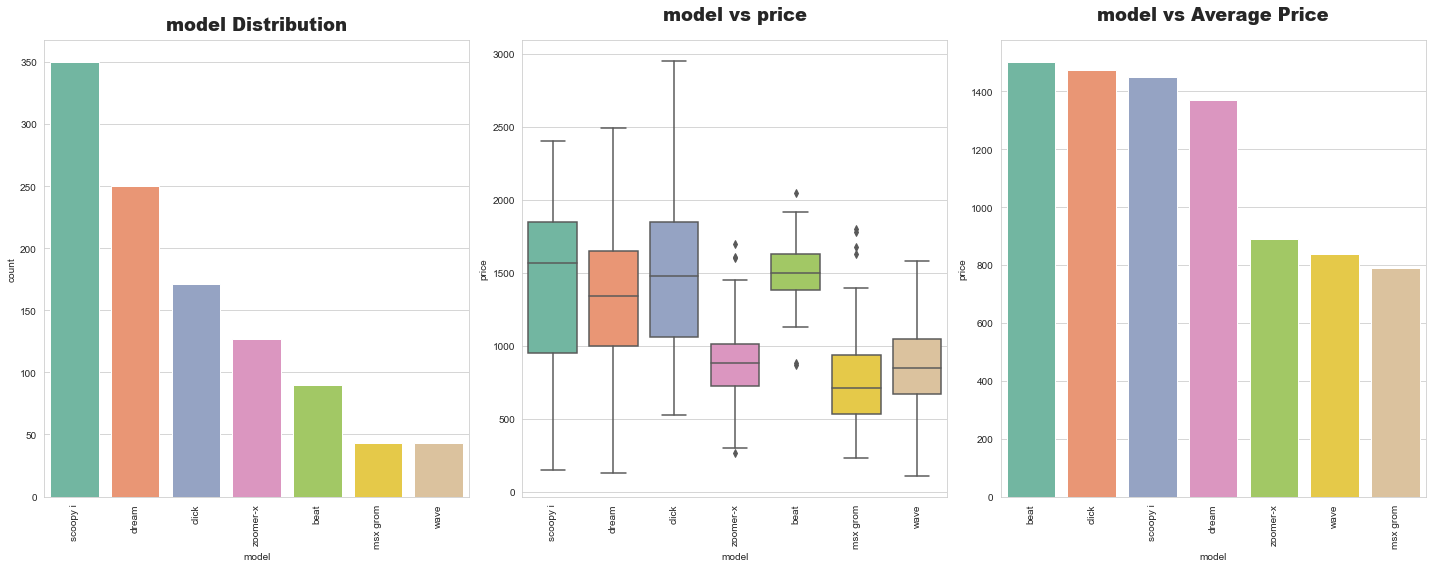

In [79]:
def categorical_visualization(cols):
    plt.figure(figsize=(20,8))
    plt.subplot(1,3,1)
    sns.countplot(x=cols,data=df_no_outlier,palette="Set2",order=df_no_outlier[cols].value_counts().index)
    plt.title(f"{cols} Distribution",pad=10,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)

    plt.subplot(1,3,2)
    sns.boxplot(x=cols,y="price",data=df_no_outlier,palette="Set2")
    plt.title(f"{cols} vs price",pad=20,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)
    
    plt.subplot(1,3,3)
    x=pd.DataFrame(df_no_outlier.groupby(cols)["price"].mean().sort_values(ascending=False))
    sns.barplot(x=x.index,y="price",data=x,palette="Set2")
    plt.title(f"{cols} vs Average Price",pad=20,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

categorical_visualization("model")

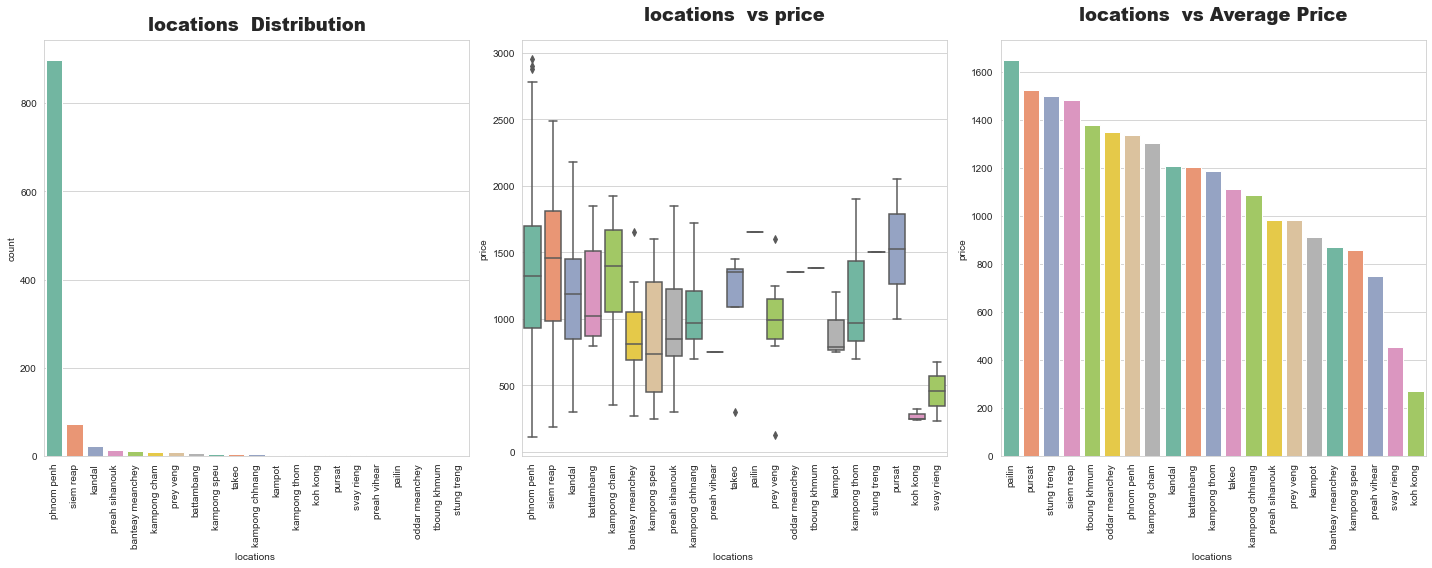

In [80]:
categorical_visualization("locations ")

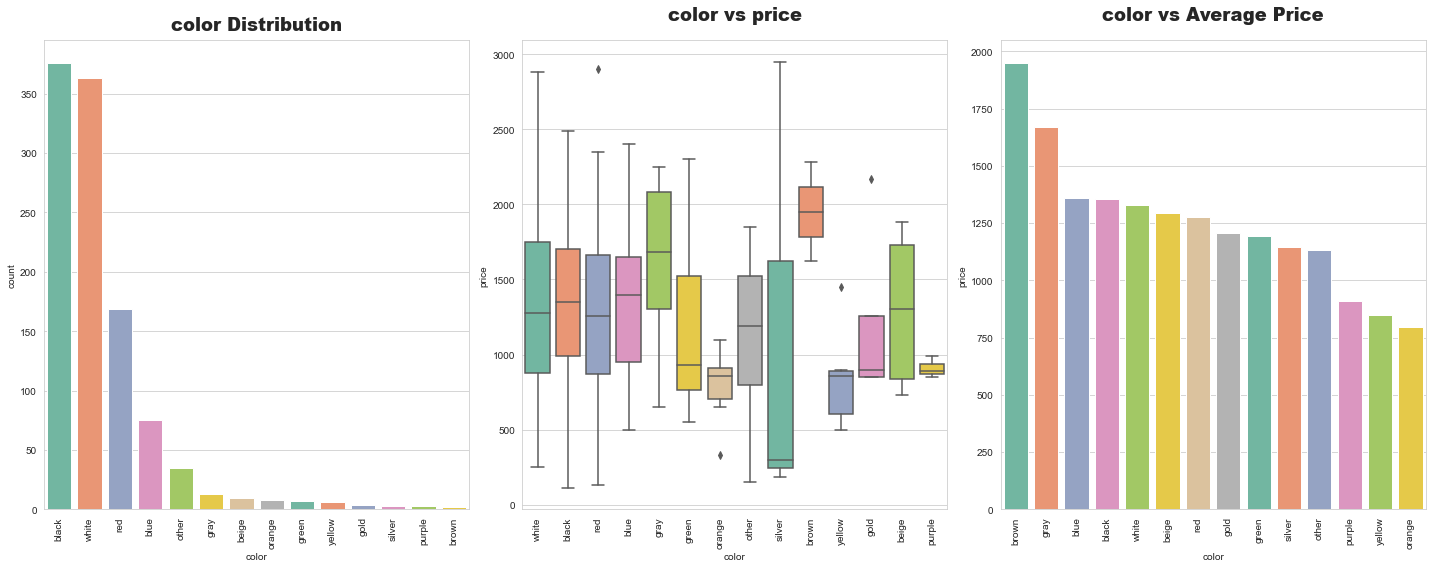

In [81]:
categorical_visualization("color")

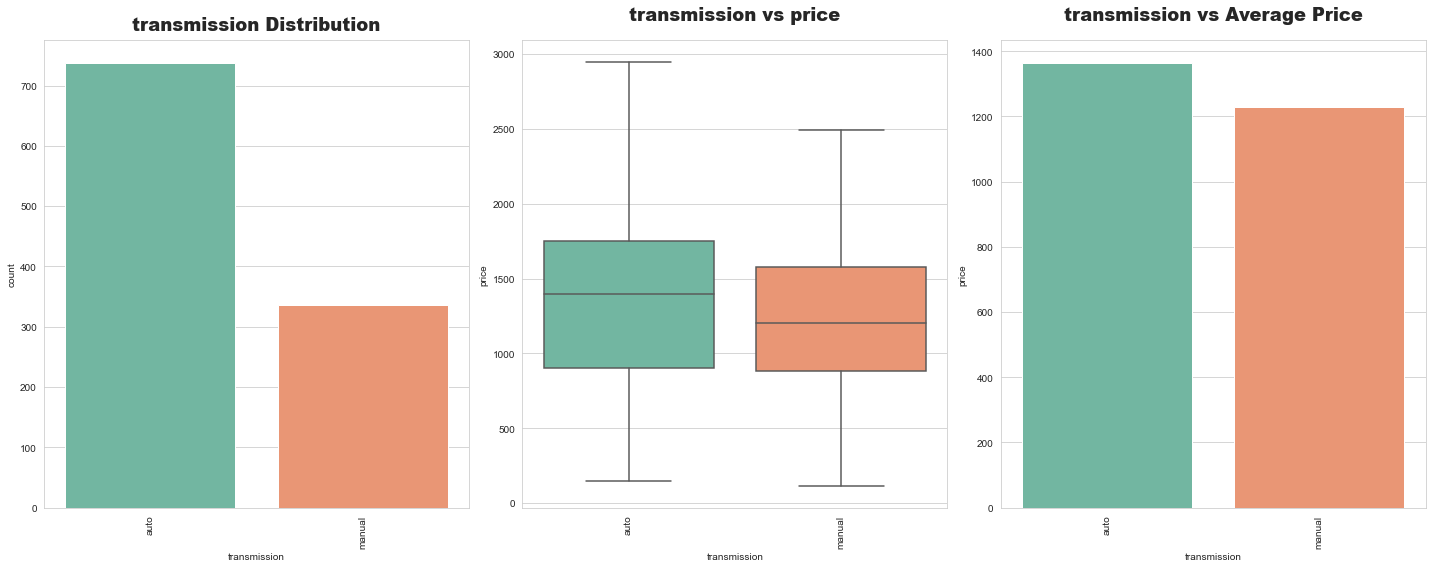

In [82]:
categorical_visualization("transmission")

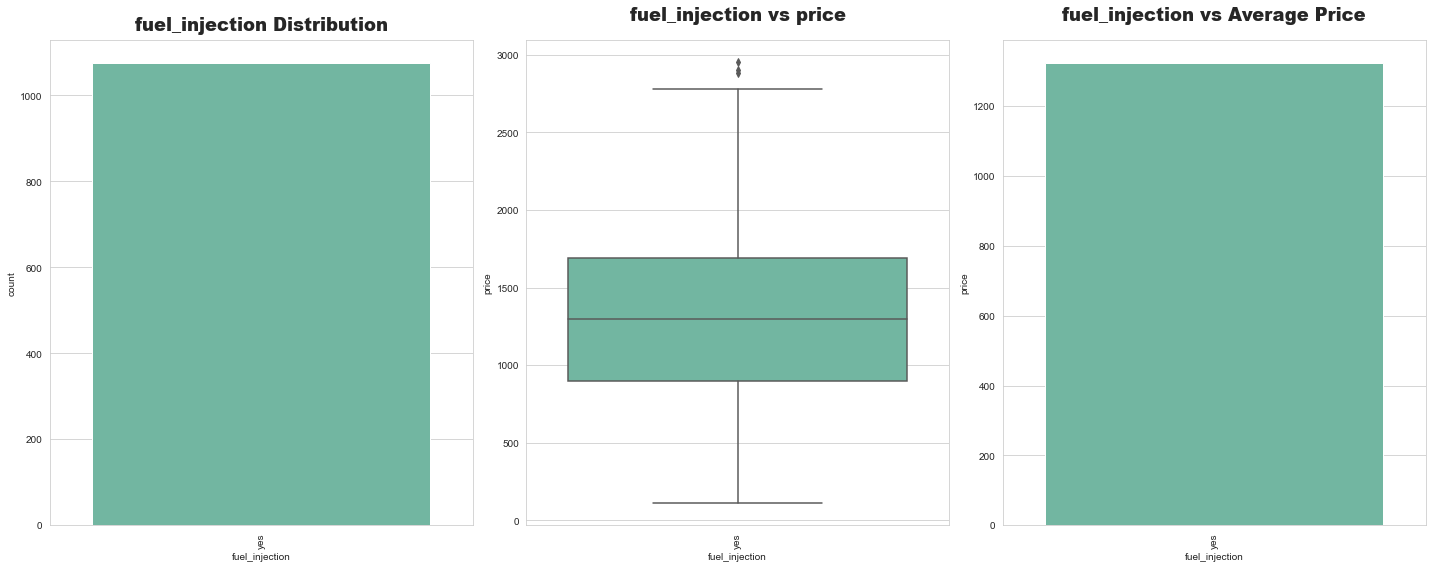

In [83]:
categorical_visualization("fuel_injection")

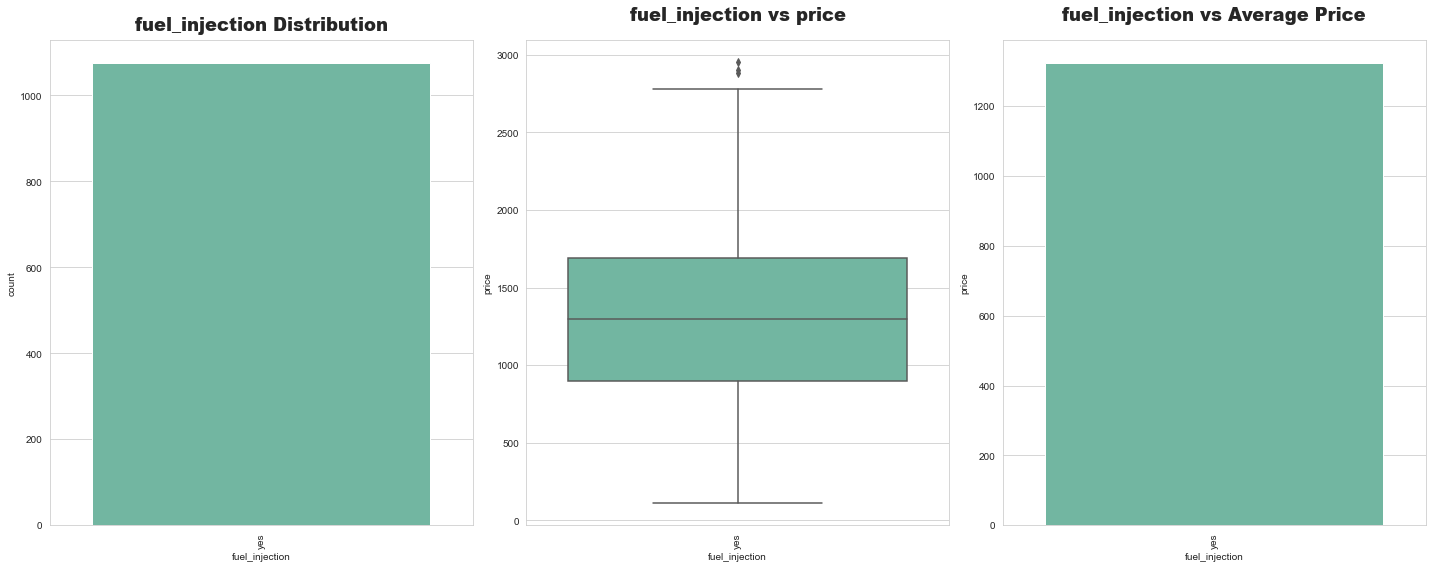

In [84]:
categorical_visualization("fuel_injection")

<blockquote style="background-color: lightcoral; padding: 10px;">
By the visualization the categorical variable is not the posible effect the ladels pridection , we can check statisticd and drop some columns
</blockquote>

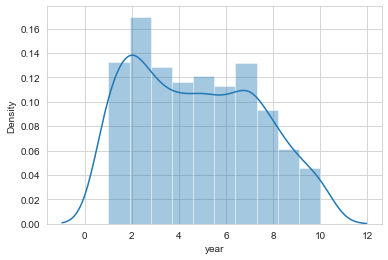

In [85]:
sns.distplot(df_no_outlier['year'])
plt.show()

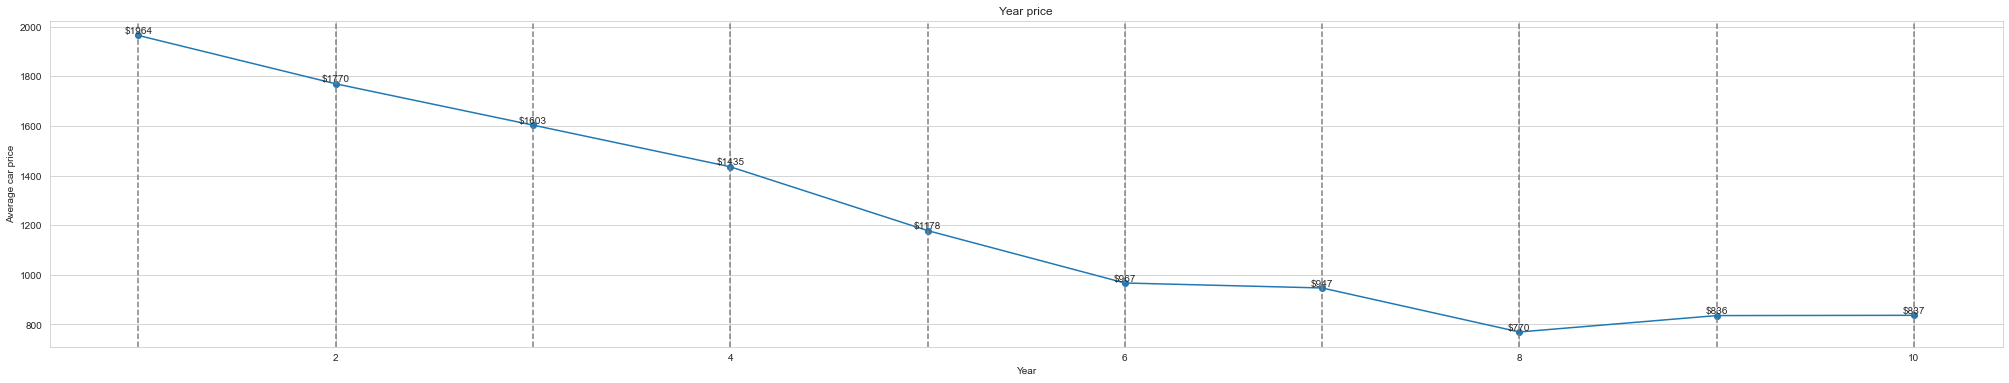

In [86]:
plt.figure(figsize=(35, 6))
mean_prices = df_no_outlier.groupby('year')['price'].mean()

# Create a line plot with markers
mean_prices.plot(marker='o')

# Add labels to the x-axis and y-axis
plt.xlabel('Year')
plt.ylabel('Average car price')
plt.title('Year price')

# Add text labels to each data point
for year, price in mean_prices.iteritems():
    plt.text(year, price, f"${price:.0f}", ha='center', va='bottom')
    plt.axvline(x=year, color='gray', linestyle='--')

plt.show()

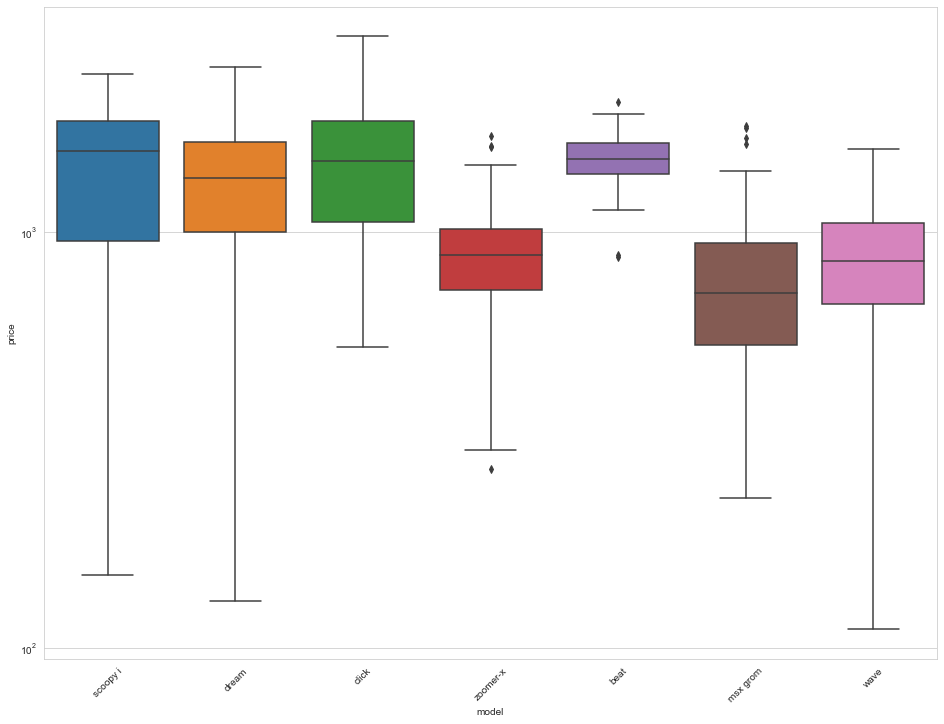

In [87]:
plt.figure(figsize = (16,12))
sns.boxplot(x = 'model', y = 'price', data = df)
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

### Descriptive Statistics Analysis.

In [88]:
df_no_outlier.describe(include='object')

,locations,model,color,fuel_type,transmission,fuel_injection
count,1074,1074,1074,1074,1074,1074
unique,21,7,14,1,2,1
top,phnom penh,scoopy i,black,gasoline,auto,yes
freq,897,350,376,1074,738,1074


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.2.4"></a>
## <b>4.2.3 <span style='color:#00008B'>corrolaton</span></b>

### [2. Handling Missing Values](https://www.kaggle.com/code/sobonmenghorng/a-guide-to-handling-missing-values-in-python/edit) 
<br>
<details>
    
<h1> Handling Missing Values in Python </h1>
    

![](https://imgur.com/68u0dD2.png)

>Real world data is messy and often contains a lot of missing values. There could be multiple  reasons for the missing values but primarily the reason for missingness can be attributed to 

| Reason for missing Data |  
|--|
|Data doesn't exist  |  
|Data not collected due to human error.  |  
|Data deleted accidently  |  
|                         |

 Either way we need to address this issue before we  proceed with the modeling stuff. It is also important to note that some algorithms like `XGBoost` and `LightGBM` can treat missing data without any preprocessing.
<hr>
    </details>

<AxesSubplot:>

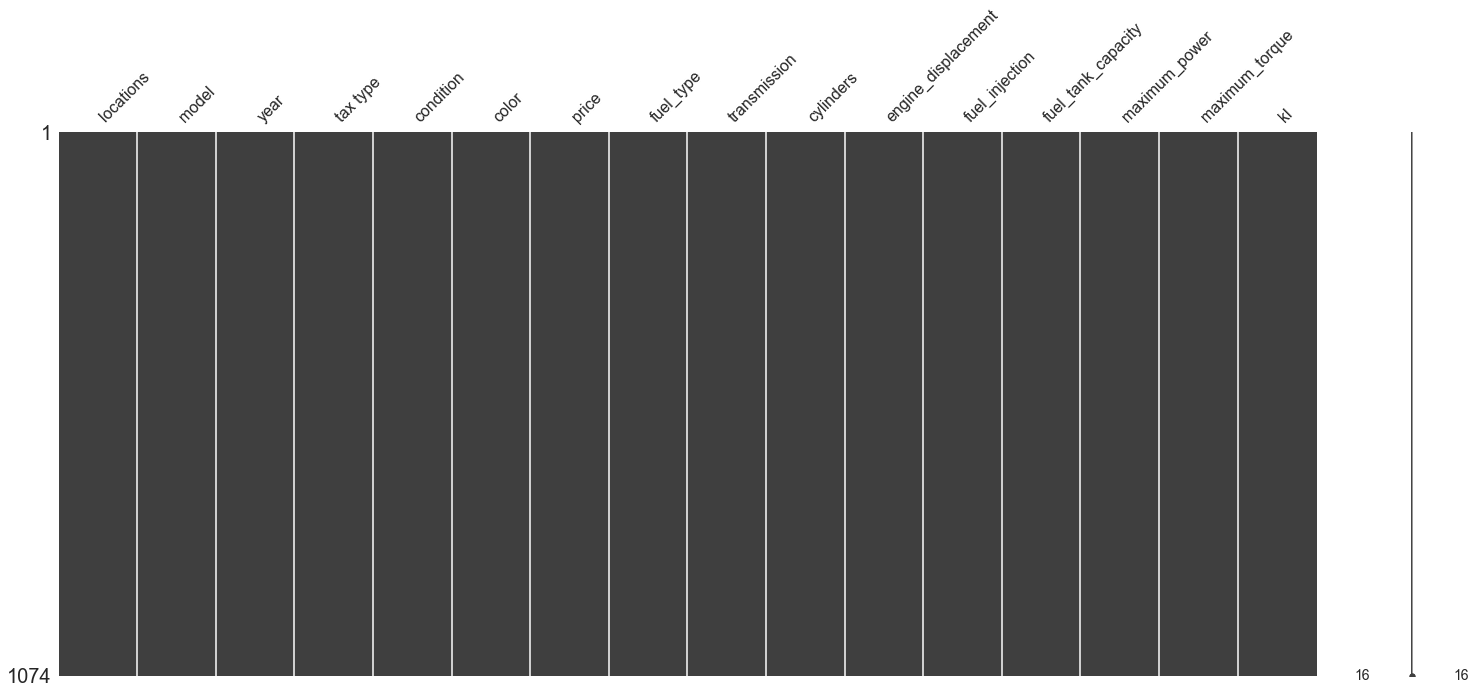

In [89]:
import missingno as msno

msno.matrix(df_no_outlier)

<AxesSubplot:>

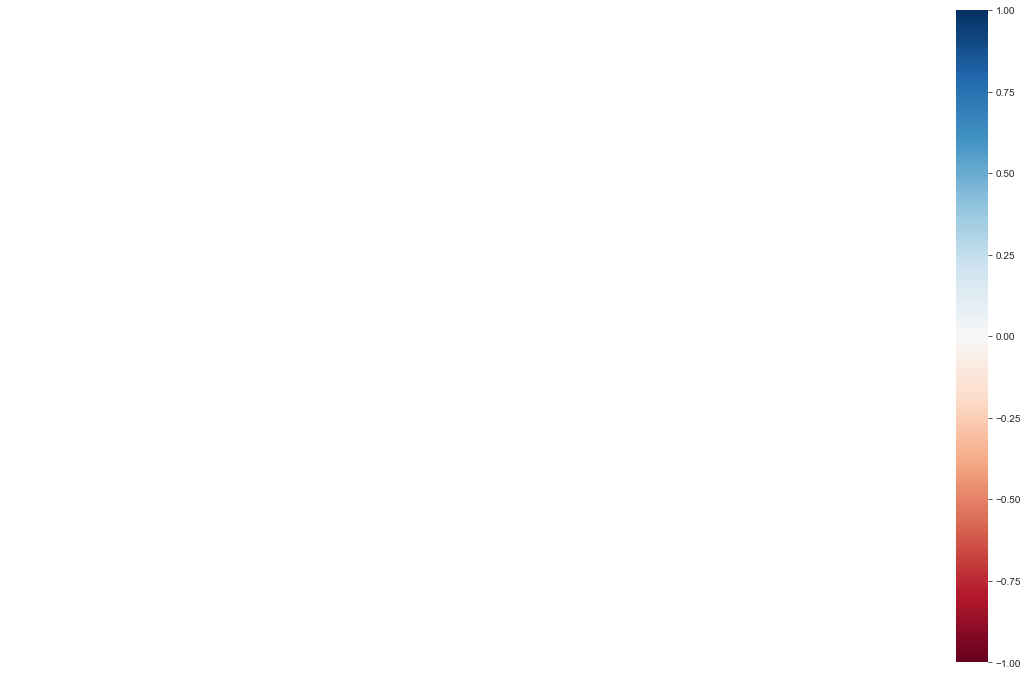

In [90]:
msno.heatmap(df_no_outlier)

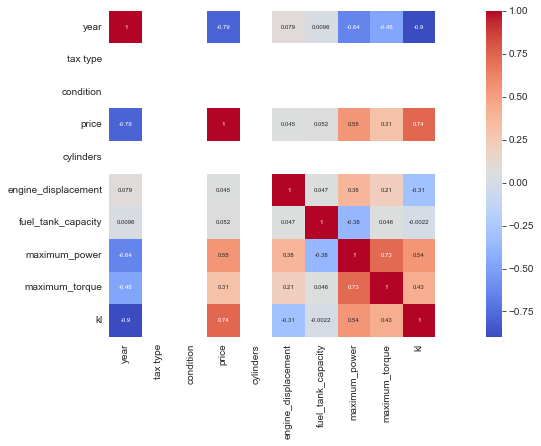

In [91]:
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(18,6))

sns.heatmap(df_no_outlier.corr(), annot= True, square=True, ax = ax, cbar= True, annot_kws={"fontsize": 6}, cmap='coolwarm')
plt.show()

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Prolem</u></b><br>
By the heatmap we see that data weak correlation and the multicorritearity and have more duplicated
</div>

In [92]:
sorted(df_no_outlier)

['color',
 'condition',
 'cylinders',
 'engine_displacement',
 'fuel_injection',
 'fuel_tank_capacity',
 'fuel_type',
 'kl',
 'locations ',
 'maximum_power',
 'maximum_torque',
 'model',
 'price',
 'tax type',
 'transmission',
 'year']

In [93]:
df_no_outlier.shape,df.shape

((1074, 16), (1074, 16))

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#222222;
            overflow:hidden;
            font-weight:700">5 <span style='color:#CDA63A'>|</span>Preprocessing </div>

In [94]:
## use Labelconding
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

df['fuel_injection']=LE.fit_transform(df['fuel_injection'])

LE = LabelEncoder()

df['transmission']=LE.fit_transform(df['transmission'])

In [95]:
df['transmission'].value_counts()

0    738
1    336
Name: transmission, dtype: int64

In [96]:
categorical_feature

['locations ', 'model', 'color', 'fuel_type', 'transmission', 'fuel_injection']

In [97]:
df_encode = pd.get_dummies(columns=categorical_feature, data = df[['locations ', 'model', 'color', 'fuel_type', 'transmission', 'fuel_injection']])

In [98]:
df_encode

,locations _banteay meanchey,locations _battambang,locations _kampong cham,locations _kampong chhnang,locations _kampong speu,locations _kampong thom,locations _kampot,locations _kandal,locations _koh kong,locations _oddar meanchey,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1523,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1524,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1


In [99]:
df_encode.columns

Index(['locations _banteay meanchey', 'locations _battambang',
       'locations _kampong cham', 'locations _kampong chhnang',
       'locations _kampong speu', 'locations _kampong thom',
       'locations _kampot', 'locations _kandal', 'locations _koh kong',
       'locations _oddar meanchey', 'locations _pailin',
       'locations _phnom penh', 'locations _preah sihanouk',
       'locations _preah vihear', 'locations _prey veng', 'locations _pursat',
       'locations _siem reap', 'locations _stung treng',
       'locations _svay rieng', 'locations _takeo', 'locations _tboung khmum',
       'model_beat', 'model_click', 'model_dream', 'model_msx grom',
       'model_scoopy i', 'model_wave', 'model_zoomer-x', 'color_beige',
       'color_black', 'color_blue', 'color_brown', 'color_gold', 'color_gray',
       'color_green', 'color_orange', 'color_other', 'color_purple',
       'color_red', 'color_silver', 'color_white', 'color_yellow',
       'fuel_type_gasoline', 'transmission_0', 'tra

In [100]:
df2 = pd.concat([df,df_encode], axis= 1)

In [101]:
df2.drop(columns= categorical_feature, axis= 1, inplace= True)

In [102]:
df2.head()

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
0,8,0,1,680.00,1,110.00,3.70,8.00,8.20,46.00,...,0,0,0,0,1,0,1,1,0,1
1,9,0,1,990.00,1,110.00,3.70,7.90,8.10,44.00,...,0,0,0,0,0,0,1,1,0,1
2,8,0,1,950.00,1,110.00,3.70,8.00,8.20,46.00,...,0,0,1,0,0,0,1,1,0,1
3,2,0,1,"1,680.00",1,110.00,3.70,8.60,8.80,58.00,...,0,0,0,0,0,0,1,1,0,1
4,3,0,1,"1,790.00",1,110.00,3.70,8.50,8.70,56.00,...,0,0,0,0,0,0,1,1,0,1


In [103]:
df2.shape

(1074, 56)

In [104]:
df4 = pd.DataFrame(df.corr().loc[:, 'price'])

In [105]:
sorted(list(df4.iloc[:, 0]))

[-0.7898813133940209,
 nan,
 nan,
 -0.12575285358269628,
 0.05172760546759515,
 0.3101197689671887,
 1.0,
 nan,
 0.044682649803570236,
 nan,
 0.5466355548499475,
 0.7388251835096625]

In [106]:
sorted(df4)

['price']

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5.2"></a>
## <b>5.1 <span style='color:#00008B'> Handling outlier</span></b>

In [107]:
z = round(df.groupby(['model'])['price'].agg(['mean']), 2)
z.T

model,beat,click,dream,msx grom,scoopy i,wave,zoomer-x
mean,"1,501.42","1,475.30","1,370.29",791.28,"1,448.48",837.91,890.84


In [108]:
min, max = z.agg(['min','max']).values

In [109]:
df1 = df.merge(z, how = 'left', on = 'model')
df1.shape, df.shape

((1074, 17), (1074, 16))

In [110]:
bin_width = (min+max)/3 
bins = [i for i in range(int(z.describe().loc['25%', 'mean']), int(np.ceil(max)), int(np.ceil(bin_width)))]
bins[-1] = int(np.ceil(max))
bins.insert(0, 0)
bins

[0, 1502]

In [111]:
new_df = df1.drop(columns=['model', 'mean'])

In [112]:
# Categorical Features
categorical_features_new_df = new_df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features_new_df

['locations ', 'color', 'fuel_type']

In [113]:
def dummy(new_df, categorical_features, threshold=None):
    if threshold is None:
        threshold = np.max(new_df[categorical_features].nunique().values.tolist())
    cat_feature = [feature for feature in categorical_features if new_df[feature].nunique() <= threshold]
    df_dummy = pd.get_dummies(columns=cat_feature, data=new_df)
    return df_dummy, cat_feature

df_dummy, col_dummy = dummy(new_df, categorical_features_new_df)
df_dummy.shape, col_dummy

((1074, 48), ['locations ', 'color', 'fuel_type'])

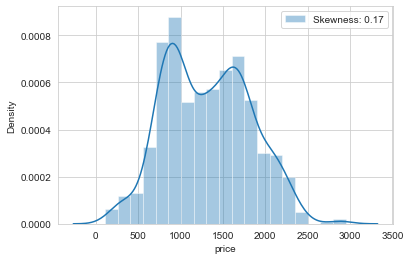

In [114]:
# initial skewness on 'Price'col
#as this is more correlated col 

t = sns.distplot(new_df["price"],label="Skewness: %.2f"%(new_df["price"].skew()) )
t.legend();

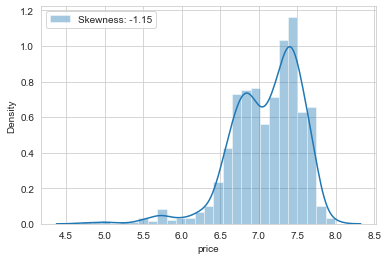

In [115]:
# after log-transform

Log_Ave = new_df["price"].map(lambda i: np.log(i) if i > 0 else 0)
t = sns.distplot(Log_Ave,label="Skewness: %.2f"%(Log_Ave.skew()) )
t.legend()

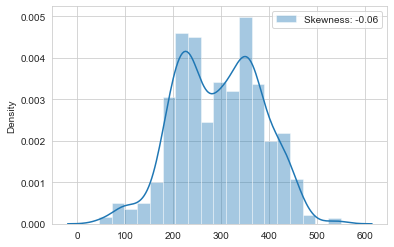

In [116]:
# from scipy import stats
from scipy.stats import boxcox
import pandas as pd
import seaborn as sns

def perform_boxcox(df, col):
    # Box-Cox transformation
    transformed_data, lambda_param = boxcox(df[col])

    Boxcox = pd.Series(transformed_data)

    t = sns.distplot(Boxcox, label="Skewness: %.2f" % (Boxcox.skew()))
    t.legend()
    return Boxcox, lambda_param

Price_boxcox, Price_lambda = perform_boxcox(new_df, 'price')


In [117]:
# To find the original data
from scipy.special import inv_boxcox

original_data = inv_boxcox(Price_boxcox, Price_lambda)
original_data.head(10)

0     680.00
1     990.00
2     950.00
3   1,680.00
4   1,790.00
5     920.00
6   1,040.00
7     970.00
8   1,560.00
9   1,962.00
dtype: float64

In [118]:
new_df['price'].head(10)

0     680.00
1     990.00
2     950.00
3   1,680.00
4   1,790.00
5     920.00
6   1,040.00
7     970.00
8   1,560.00
9   1,962.00
Name: price, dtype: float64

In [119]:
new_df_boxcox = df_dummy.copy()
new_df_boxcox['price'] = list(Price_boxcox)

The IQR is 136.63265951323123
The lower bound value is 18.22285290013619
The upper bound value is 564.7534909530611
Total number of outliers are 0


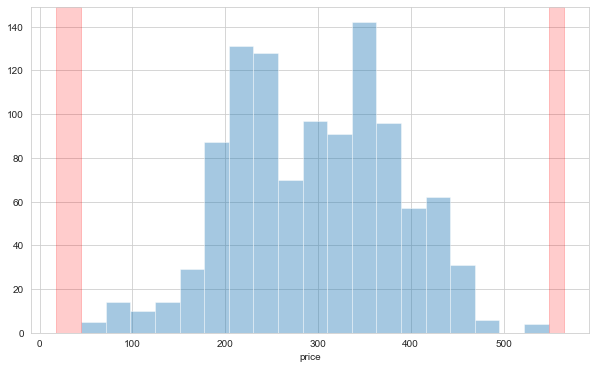

In [120]:
visulize_outlier(new_df_boxcox, 'price')

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5.1"></a>
## <b>5.2 <span style='color:#00008B'>Feature Selection and Importance</span></b>
* SelectKbest  
    * Strong relation with the output/target
* Recursive Feature Elimination

In [121]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection  import chi2

In [122]:
# Features and Labels
df2.head()

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
0,8,0,1,680.00,1,110.00,3.70,8.00,8.20,46.00,...,0,0,0,0,1,0,1,1,0,1
1,9,0,1,990.00,1,110.00,3.70,7.90,8.10,44.00,...,0,0,0,0,0,0,1,1,0,1
2,8,0,1,950.00,1,110.00,3.70,8.00,8.20,46.00,...,0,0,1,0,0,0,1,1,0,1
3,2,0,1,"1,680.00",1,110.00,3.70,8.60,8.80,58.00,...,0,0,0,0,0,0,1,1,0,1
4,3,0,1,"1,790.00",1,110.00,3.70,8.50,8.70,56.00,...,0,0,0,0,0,0,1,1,0,1


In [123]:
df2.columns

Index(['year', 'tax type', 'condition', 'price', 'cylinders',
       'engine_displacement', 'fuel_tank_capacity', 'maximum_power',
       'maximum_torque', 'kl', 'locations _banteay meanchey',
       'locations _battambang', 'locations _kampong cham',
       'locations _kampong chhnang', 'locations _kampong speu',
       'locations _kampong thom', 'locations _kampot', 'locations _kandal',
       'locations _koh kong', 'locations _oddar meanchey', 'locations _pailin',
       'locations _phnom penh', 'locations _preah sihanouk',
       'locations _preah vihear', 'locations _prey veng', 'locations _pursat',
       'locations _siem reap', 'locations _stung treng',
       'locations _svay rieng', 'locations _takeo', 'locations _tboung khmum',
       'model_beat', 'model_click', 'model_dream', 'model_msx grom',
       'model_scoopy i', 'model_wave', 'model_zoomer-x', 'color_beige',
       'color_black', 'color_blue', 'color_brown', 'color_gold', 'color_gray',
       'color_green', 'color_ora

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

from pandas_profiling import ProfileReport

In [125]:
df2.describe() 

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
count,"1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00",...,"1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00"
mean,4.74,0.00,1.00,"1,322.29",1.00,112.78,5.13,8.20,8.67,51.15,...,0.03,0.00,0.16,0.00,0.34,0.01,1.00,0.69,0.31,1.00
std,2.65,0.00,0.00,505.84,0.00,6.13,1.69,0.39,0.49,6.74,...,0.18,0.05,0.36,0.05,0.47,0.07,0.00,0.46,0.46,0.00
min,1.00,0.00,1.00,111.00,1.00,108.20,3.70,7.40,6.80,37.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
25%,2.00,0.00,1.00,900.00,1.00,110.00,3.70,7.90,8.40,45.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
50%,5.00,0.00,1.00,"1,300.00",1.00,110.00,4.40,8.20,8.69,51.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
75%,7.00,0.00,1.00,"1,690.00",1.00,110.00,5.50,8.50,8.89,58.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00
max,10.00,0.00,1.00,"2,950.00",1.00,125.00,8.00,9.60,10.80,63.70,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [126]:
from sklearn.preprocessing import MinMaxScaler
scalar  = MinMaxScaler()
scaled_data = scalar.fit_transform(df2)

In [127]:
scaled_data

array([[0.77777778, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.88888889, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.77777778, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.22222222, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [128]:
features = pd.DataFrame(scaled_data, columns=df2.columns)
features

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
0,0.78,0.00,0.00,0.20,0.00,0.11,0.00,0.27,0.35,0.34,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1,0.89,0.00,0.00,0.31,0.00,0.11,0.00,0.23,0.32,0.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.78,0.00,0.00,0.30,0.00,0.11,0.00,0.27,0.35,0.34,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.11,0.00,0.00,0.55,0.00,0.11,0.00,0.55,0.50,0.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.22,0.00,0.00,0.59,0.00,0.11,0.00,0.50,0.47,0.71,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,0.56,0.00,0.00,0.20,0.00,0.11,0.07,0.18,0.20,0.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1070,0.33,0.00,0.00,0.00,0.00,0.11,0.07,0.27,0.30,0.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1071,1.00,0.00,0.00,0.21,0.00,0.11,0.07,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1072,0.33,0.00,0.00,0.33,0.00,0.11,0.07,0.27,0.30,0.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [129]:
features.describe()

,year,tax type,condition,price,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
count,"1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00",...,"1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00","1,074.00"
mean,0.42,0.00,0.00,0.43,0.00,0.27,0.33,0.36,0.47,0.53,...,0.03,0.00,0.16,0.00,0.34,0.01,0.00,0.69,0.31,0.00
std,0.29,0.00,0.00,0.18,0.00,0.36,0.39,0.18,0.12,0.25,...,0.18,0.05,0.36,0.05,0.47,0.07,0.00,0.46,0.46,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.11,0.00,0.00,0.28,0.00,0.11,0.00,0.23,0.40,0.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.44,0.00,0.00,0.42,0.00,0.11,0.16,0.36,0.47,0.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,0.67,0.00,0.00,0.56,0.00,0.11,0.42,0.50,0.52,0.79,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00
max,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00


In [130]:
ylabels = features['price']
ylabels

0      0.20
1      0.31
2      0.30
3      0.55
4      0.59
       ... 
1069   0.20
1070   0.00
1071   0.21
1072   0.33
1073   0.45
Name: price, Length: 1074, dtype: float64

In [131]:
features.columns

Index(['year', 'tax type', 'condition', 'price', 'cylinders',
       'engine_displacement', 'fuel_tank_capacity', 'maximum_power',
       'maximum_torque', 'kl', 'locations _banteay meanchey',
       'locations _battambang', 'locations _kampong cham',
       'locations _kampong chhnang', 'locations _kampong speu',
       'locations _kampong thom', 'locations _kampot', 'locations _kandal',
       'locations _koh kong', 'locations _oddar meanchey', 'locations _pailin',
       'locations _phnom penh', 'locations _preah sihanouk',
       'locations _preah vihear', 'locations _prey veng', 'locations _pursat',
       'locations _siem reap', 'locations _stung treng',
       'locations _svay rieng', 'locations _takeo', 'locations _tboung khmum',
       'model_beat', 'model_click', 'model_dream', 'model_msx grom',
       'model_scoopy i', 'model_wave', 'model_zoomer-x', 'color_beige',
       'color_black', 'color_blue', 'color_brown', 'color_gold', 'color_gray',
       'color_green', 'color_ora

In [132]:
xfeatures = features[['year', 'tax type', 'condition', 'cylinders',
       'engine_displacement', 'fuel_tank_capacity', 'maximum_power',
       'maximum_torque', 'kl', 'locations _banteay meanchey',
       'locations _battambang', 'locations _kampong cham',
       'locations _kampong chhnang', 'locations _kampong speu',
       'locations _kampong thom', 'locations _kampot', 'locations _kandal',
       'locations _koh kong', 'locations _oddar meanchey', 'locations _pailin',
       'locations _phnom penh', 'locations _preah sihanouk',
       'locations _preah vihear', 'locations _prey veng', 'locations _pursat',
       'locations _siem reap', 'locations _stung treng',
       'locations _svay rieng', 'locations _takeo', 'locations _tboung khmum',
       'model_beat', 'model_click', 'model_dream', 'model_msx grom',
       'model_scoopy i', 'model_wave', 'model_zoomer-x', 'color_beige',
       'color_black', 'color_blue', 'color_brown', 'color_gold', 'color_gray',
       'color_green', 'color_orange', 'color_other', 'color_purple',
       'color_red', 'color_silver', 'color_white', 'color_yellow',
       'fuel_type_gasoline', 'transmission_0', 'transmission_1',
       'fuel_injection_0']]
xfeatures

,year,tax type,condition,cylinders,engine_displacement,fuel_tank_capacity,maximum_power,maximum_torque,kl,locations _banteay meanchey,...,color_other,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_gasoline,transmission_0,transmission_1,fuel_injection_0
0,0.78,0.00,0.00,0.00,0.11,0.00,0.27,0.35,0.34,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1,0.89,0.00,0.00,0.00,0.11,0.00,0.23,0.32,0.26,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.78,0.00,0.00,0.00,0.11,0.00,0.27,0.35,0.34,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.11,0.00,0.00,0.00,0.11,0.00,0.55,0.50,0.79,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.22,0.00,0.00,0.00,0.11,0.00,0.50,0.47,0.71,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,0.56,0.00,0.00,0.00,0.11,0.07,0.18,0.20,0.30,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1070,0.33,0.00,0.00,0.00,0.11,0.07,0.27,0.30,0.45,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1071,1.00,0.00,0.00,0.00,0.11,0.07,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1072,0.33,0.00,0.00,0.00,0.11,0.07,0.27,0.30,0.45,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Convert ylabels to an array-like object
ylabels = np.array(ylabels)

# Encode the labels if they are not already in integer format
label_encoder = LabelEncoder()
ylabels_encoded = label_encoder.fit_transform(ylabels)

# Create an instance of SelectKBest with mutual information as the score function
skb = SelectKBest(score_func=mutual_info_classif, k=10)
best_feature_fit = skb.fit(xfeatures, ylabels_encoded)


In [ ]:
# Highest score shows the best fit
print("Scores",best_feature_fit.scores_)

In [ ]:
# Transform(Optional)
bf_02 = best_feature_fit.transform(xfeatures)

In [ ]:
bf_02

In [ ]:
# Mapping to Feature Name
feature_scores = pd.DataFrame(best_feature_fit.scores_,columns=['Feature_Scores'])

In [ ]:
feature_scores

In [ ]:
feature_column_names = pd.DataFrame(xfeatures.columns,columns=['Feature_name'])
best_feat_df = pd.concat([feature_scores,feature_column_names],axis=1)

In [ ]:
best_feat_df

In [ ]:
# Get the best
# The higher the number the more important the feature
best_feat_df.nlargest(10,'Feature_Scores')

In [ ]:
best_feat_df.nlargest(12,'Feature_Scores')

In [ ]:
best_feat_df.nlargest(12,'Feature_Scores')['Feature_name'].unique()

## Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

xfeatures_array = xfeatures.values
regression_model = LinearRegression()
rfe = RFE(estimator=regression_model, n_features_to_select=8)
rfe_fit = rfe.fit(xfeatures_array, ylabels)
selected_feature_indices = rfe_fit.support_
selected_features = xfeatures_array[:, selected_feature_indices]

In [ ]:
# Selection
selected_features = pd.DataFrame(rfe_fit.support_,columns=['Selected_Features'])
ranking_features = pd.DataFrame(rfe_fit.ranking_,columns=['ranking_Features'])

In [ ]:
rfe_feature_df = pd.concat([feature_column_names,selected_features,ranking_features],axis=1)

In [ ]:
rfe_feature_df

## Narative
* RFE we will eliminate the lowest ranting or true
# Checking for Feature Importance
* ExtraTreeClassifier
* Which feature 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Perform binning to convert continuous labels into discrete categories
n_bins = 5  # Specify the number of bins
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
ylabels_discrete = discretizer.fit_transform(ylabels.reshape(-1, 1)).flatten()

# Initialize and fit the ExtraTreesClassifier
et_clf = ExtraTreesClassifier()
et_clf.fit(xfeatures, ylabels_discrete)

In [ ]:
# Print Important
print(et_clf.feature_importances_)

In [ ]:
feature_imporance_df = pd.Series(et_clf.feature_importances_,index=xfeatures.columns)

In [ ]:
feature_imporance_df

In [ ]:
feature_imporance_df.nlargest(12).plot(kind='barh')

In [ ]:
xfeatures_best = feature_imporance_df.nlargest(12)
pd.DataFrame(xfeatures_best)

In [ ]:
label_name = xfeatures_best.index[0:12]
label_name

## Model Building
* Feature & Labels
* Train/Test/Split
* Mutiple Regresssion 
* RF
* DCT
* Serialize

In [ ]:
training_score = []
testing_score = []

In [ ]:
xfeatures_best = xfeatures[['year', 'kl', 'maximum_power', 'maximum_torque', 'model_zoomer-x',
       'model_beat', 'color_black', 'fuel_tank_capacity', 'color_red',
       'color_white', 'locations _phnom penh', 'engine_displacement']]
xfeatures_best 

In [ ]:
training_score = []
testing_score = []

In [ ]:
from sklearn.metrics import r2_score
def model_prediction(x_train, x_test, y_train, y_test, model):
    
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    a = r2_score(y_train, y_train_pred)*100
    b = r2_score(y_test, y_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"r2_Score of {model} model on Training Data is:",a)
    print(f"r2_Score of {model} model on Testing Data is:",b)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xfeatures_best, ylabels, test_size=0.3,random_state=144)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model_prediction(x_train, x_test, y_train, y_test, lm)

In [ ]:
lm.score(x_test,y_test)

In [ ]:
# Let's create a function to create adjusted R-squared
def adj_r2(x,y):
    r2 = lm.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adjusted_r2
    

In [ ]:
adj_r2(x_test,y_test)

In [ ]:
lm.coef_

In [ ]:
lm.intercept_

In [ ]:
xfeatures

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures, ylabels, test_size=0.3,random_state=144)

In [ ]:
Algorithms = {'Training Score': [],
        'Testing Score' : [],
        'Algorithms': []
        }


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def model_prediction(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    a = r2_score(y_train, y_train_pred) * 100
    b = r2_score(y_test, y_test_pred) * 100

    Algorithms['Algorithms'].append(model.__class__.__name__)
    Algorithms['Training Score'].append(a)
    Algorithms['Testing Score'].append(b)

    print(f"r2_Score of {model.__class__.__name__} model on Training Data is:", a)
    print(f"r2_Score of {model.__class__.__name__} model on Testing Data is:", b)
    print(f"MSE of {model.__class__.__name__} model on Testing Data is:", mean_squared_error(y_test_pred, y_test))


<a id="1.3"></a>
<h2 style="font-family: Verdana; font-size: 22px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><b>1. Linear-Regression </b> Model</h2>

In [ ]:
from sklearn.linear_model import LinearRegression

model_prediction(X_train, X_test, y_train, y_test, LinearRegression())


In [ ]:
lm

In [ ]:
def features_importance(x_train, y_train, lm):
    lm.fit(x_train, y_train)

    df_importance_l_d = pd.DataFrame()
    df_importance_l_d['Features'] = x_train.columns
    df_importance_l_d['Score'] = lm.coef_

    plt.figure(figsize = (15, 6))

    sns.barplot(x= 'Features', y = 'Score', data = df_importance_l_d )
    plt.xticks(rotation = 90)
    plt.show()

In [ ]:
lm = LinearRegression()
features_importance(X_train, y_train, lm)

In [ ]:
def residual_plot(X_train, X_test, y_train, y_test, lm):
    from scipy.stats import shapiro
    
    lm.fit(X_train, y_train)
    y_test_pred = lm.predict(X_test)
    residuals = y_test - y_test_pred
    
#     # normality test
#     stat, p = normaltest(residuals)
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret results
#     alpha = 0.05
#     if p > alpha:
#         print('Sample looks Gaussian (fail to reject H0)')
#     else:
#         print('Sample does not look Gaussian (reject H0)')
        
        
    # normality test
    stat, p = shapiro(residuals)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret results
    alpha = 0.05
    if p > alpha:
        print('Residual looks Gaussian (fail to reject H0)')
    else:
        print('Residual does not look Gaussian (reject H0)')
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    sns.distplot(residuals, bins=20)
    plt.title('Distribution of Residuals')
    plt.xlabel('Errors')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, y_test_pred, label="Predicted vs Actual")
    plt.plot(y_test, y_test, 'r', label="Perfect Prediction")
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual prices')
    plt.ylabel('Predicted prices')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    

    sm.qqplot(residuals, line='s')
    plt.title('QQ Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
    plt.show()

In [ ]:
residual_plot(X_train, X_test, y_train, y_test,lm)

In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(df.price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Residual looks Gaussian (fail to reject H0)')
else:
    print('Residual does not look Gaussian (reject H0)')

In [ ]:
Log_Ave = df["price"].map(lambda i: np.log(i) if i > 0 else 0)
t = sns.distplot(Log_Ave,label="Skewness: %.2f"%(Log_Ave.skew()) )
t.legend()

In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(Log_Ave)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Residual looks Gaussian (fail to reject H0)')
else:
    print('Residual does not look Gaussian (reject H0)')

In [ ]:
# Adding a constant variable and Build a first fitted model
import statsmodels.api as sm  

def ODL_checking(X_train_rfec, y_train):
    X_train_rfec = sm.add_constant(X_train_rfec)
    lm_rfe = sm.OLS(y_train,X_train_rfec).fit()

    #Summary of linear model
    print(lm_rfe.summary())
    return lm_rfe

In [ ]:
ODL_checking(X_train, y_train) 

In [ ]:
import statsmodels.api as sm

def drop_high_pvalue_features(X, y, alpha=0.050):
    """
    Drops one feature at a time based on the p-value until all p-values are less than or equal to the specified alpha level.
    
    Parameters:
        X (pandas DataFrame): The DataFrame containing the independent variables.
        y (pandas Series): The Series containing the dependent variable.
        alpha (float): The alpha level above which features will be dropped. Default is 0.05.
    
    Returns:
        pandas DataFrame: The DataFrame with high p-value features dropped.
    """
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Iterate until all p-values are less than or equal to the alpha level
    while results.pvalues.max() > alpha:
        # Drop the feature with the highest p-value
        drop_feature = results.pvalues.idxmax()
        X = X.drop(columns=[drop_feature], axis='columns')
        # Fit a new OLS model with the remaining features
        model = sm.OLS(y, X)
        results = model.fit()
    
    return X

In [ ]:
X_train_new = drop_high_pvalue_features(X_train, y_train)
ODL_checking(X_train_new, y_train)

In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF(X_train_rfe):
    vif = pd.DataFrame()
    vif['Features'] = X_train_rfe.columns
    vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False) 
    vif = vif.reset_index(drop = True)
    return vif

In [ ]:
VIF(X_train_new)

In [ ]:
def drop_high_vif_features(features, vif_thresh=5):
    """
    Drops one feature at a time based on the VIF value until all VIF values are less than or equal to the specified threshold.
    
    Parameters:
        df (pandas DataFrame): The DataFrame to check for high VIF values.
        vif_thresh (float): The threshold VIF value above which features will be dropped. Default is 5.
    
    Returns:
        pandas DataFrame: The DataFrame with high VIF features dropped.
    """
    vifs = pd.Series([variance_inflation_factor(features.values, i) for i in range(features.shape[1])], index=features.columns)
    
    # Iterate until all VIF values are less than or equal to the threshold
    while vifs.max() > vif_thresh:
        # Drop the feature with the highest VIF value
        drop_feature = vifs.idxmax()
        features = features.drop(columns=[drop_feature])
        
        # Re-calculate VIF values for remaining features
        vifs = pd.Series([variance_inflation_factor(features.values, i) for i in range(features.shape[1])], index=features.columns)
    
    return features

In [ ]:
X_train_new1 = drop_high_vif_features(X_train_new)
VIF(X_train_new1) 

In [ ]:
ODL_checking(X_train_new1, y_train) 

In [ ]:
X_train_new2 = drop_high_pvalue_features(X_train_new1, y_train)
ODL_checking(X_train_new2, y_train)

<a id="1.3"></a>
<h2 style="font-family: Verdana; font-size: 22px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><b>2. Ridge Regressor </b> Model</h2>

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def model_prediction(x_train, x_test, y_train, y_test, model, name):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    a = r2_score(y_train, y_train_pred) * 100
    b = r2_score(y_test, y_test_pred) * 100

    Algorithms['Algorithms'].append(name)
    Algorithms['Training Score'].append(a)
    Algorithms['Testing Score'].append(b)

    print(f"r2_Score of {name} model on Training Data is:", a)
    print(f"r2_Score of {name} model on Testing Data is:", b)
    print(f"MSE of {name} model on Testing Data is:", mean_squared_error(y_test_pred, y_test))


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV

ridgecv = RidgeCV(alphas=np.logspace(-2, 3, num=50))
ridgecv.fit(x_train, y_train)
alpha = ridgecv.alpha_
model_prediction(X_train, X_test, y_train, y_test, Ridge(alpha=alpha), 'Ridge Regression Model')


In [ ]:
residual_plot(x_train, x_test, y_train, y_test, Ridge(alpha=alpha))

<a id="1.3"></a>
<h2 style="font-family: Verdana; font-size: 22px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><b>3. Lasso Regressor </b> Model</h2>

In [ ]:
from sklearn.linear_model import Lasso, LassoCV

lasso_cv = LassoCV(alphas=np.logspace(-2, 3, num=50))
lasso_cv.fit(x_train, y_train)
alpha = lasso_cv.alpha_
model_prediction(X_train, X_test, y_train, y_test, Lasso(alpha=alpha), 'Lasso Regresion Model')

features_importance(X_train, y_train, Lasso(alpha=alpha))

In [ ]:
residual_plot(X_train, X_test, y_train, y_test, Lasso(alpha=alpha))

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import normaltest
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


from IPython.display import clear_output
# !pip3 install -U lazypredict
# !pip3 install -U pandas #Upgrading pandas

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
clear_output()

In [ ]:
def model_prediction(x_train, x_test, y_train, y_test, model, name, record = False):
    model.fit(x_train,y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    a = r2_score(y_train,y_train_pred)*100
    b = r2_score(y_test,y_test_pred)*100
    
    if record:
        Algorithms['Algorithms'].append(name)
        Algorithms['Training Score'].append(a)
        Algorithms['Testing Score'].append(b)
    
    print(f"r2_Score of {model} model on Training Data is:",a)
    print(f"r2_Score of {model} model on Testing Data is:",b)
    print(f"MSE of {model} model on Testing Data is:", mean_squared_error(y_test_pred, y_test))

In [ ]:
def visualize_linear_features_importance(x_train, y_train, lm):
    
    if isinstance(lm, Pipeline):
        lm = lm.named_steps['model']
        
    lm.fit(x_train, y_train)

    df_importance_l_d = pd.DataFrame()
    df_importance_l_d['Features'] = x_train.columns
    df_importance_l_d['Score'] = lm.coef_

    plt.figure(figsize = (15, 6))

    sns.barplot(x= 'Features', y = 'Score', data = df_importance_l_d )
    plt.xticks(rotation = 90)
    plt.show()

In [ ]:
Input_linear =[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
Input_ridge = [ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',Ridge())]
Input_lasso = [ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',Lasso())]


polynormail = Pipeline(steps=Input_linear)
ridge_poly = Pipeline(Input_ridge)
lasso_poly = Pipeline(Input_lasso)

In [ ]:
param_grid = {
    "polynomial__degree": [1, 2, 3]
#     "model__normalize":[True, False]
}
# Input_linear = Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())])
search_poly = GridSearchCV(polynormail, param_grid, n_jobs=1).fit(x_train, y_train)
polynomial_best = search_poly.best_estimator_
model_prediction(X_train, X_test, y_train, y_test, polynomial_best, 'Polynomial Regression Model', record=True)
visualize_linear_features_importance(x_train, y_train, polynomial_best)

In [ ]:
residual_plot(x_train, x_test, y_train, y_test, polynomial_best)

### 3.1 Ridge Polynormail 

In [ ]:
param_grid = {
    "polynomial__degree": [1, 2, 3],
    "model__alpha": np.logspace(-2, 3, num=50)
#     "model__normalize":[True, False]
}
search_ridge = GridSearchCV(ridge_poly, param_grid, n_jobs=1).fit(x_train, y_train)
ridge_best=search_ridge.best_estimator_
model_prediction(x_train, x_test, y_train, y_test,ridge_best, 'Ridge Poly Regresion Model',  record=True)
visualize_linear_features_importance(X_train, y_train, ridge_best)

In [ ]:
residual_plot(x_train, x_test, y_train, y_test, ridge_best)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:120%;
          text-align:center;">
<a id = '6'><span>3.2 Lasso Polynormail</span></a>
</p>
</div>

In [ ]:
param_grid = {
    "polynomial__degree": [1, 2, 3],
    "model__alpha": np.logspace(-2, 3, num=50)
#     "model__normalize":[True, False]
}
search_lasso = GridSearchCV(lasso_poly, param_grid, n_jobs=1).fit(x_train, y_train)
lasso_best=search_lasso.best_estimator_
model_prediction(x_train, x_test, y_train, y_test,lasso_best, 'Lasso Poly Regresion Model',  record=True)
visualize_linear_features_importance(X_train, y_train, lasso_best)

In [ ]:
residual_plot(X_train, X_test, y_train, y_test, lasso_best)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:120%;
          text-align:center;">
All Model Performance Comparison
</p>
</div>

In [ ]:
df_model = pd.DataFrame.from_dict(Algorithms)
df_model

In [ ]:
df_model = df_model.drop(3)


In [ ]:
df_model.plot(x="Algorithms",y=["Training Score","Testing Score"], figsize=(16,6),kind="bar",
        title="Performance Visualization of Different Models",colormap="Set1")
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:120%;
          text-align:center;">
<a id = '6'><span>Model Building Regression Another Tenique</span></a>
</p>
</div>

In [ ]:
df_no_outlier

In [ ]:
df_no_outlier = df_no_outlier.drop(columns=['locations ','color','fuel_type','fuel_injection'])

In [ ]:
df_no_outlier.columns

In [ ]:
df_no_outlier

In [ ]:
model_mapping = {
    "scoopy i": 1,
    "dream": 2,
    "click": 3,
    "zoomer-x": 4,
    "beat": 5,
    "msx grom": 6,
    "wave": 7
}

df_no_outlier['model'] = df_no_outlier['model'].replace(model_mapping)

In [ ]:
df_no_outlier

In [ ]:
model_mapping1 = {
    "auto": 1,
    "manual": 2,
}

df_no_outlier['transmission'] = df_no_outlier['transmission'].replace(model_mapping1)

In [ ]:
x = df_no_outlier
x

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,15):
    kmean = KMeans(n_clusters=i , init='k-means++' , random_state=30)
    kmean.fit(x)
    wcss.append(kmean.inertia_)
wcss 

In [ ]:
plt.plot(range(1,15)  , wcss)

In [ ]:
kmean1= KMeans(n_clusters=5 ,init = 'k-means++' , random_state=30)
kmean1.fit_predict(x)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Select the features for clustering
features = df[['price', 'transmission', 'cylinders', 'engine_displacement', 'fuel_tank_capacity',
               'maximum_power', 'maximum_torque', 'kl']]

# Create an instance of KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=30)

# Fit the KMeans model to your data and make predictions
labels = kmeans.fit_predict(features)

# Get the centroids
centroids = kmeans.cluster_centers_

# Create a scatter plot
plt.scatter(features['price'], features['maximum_power'], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 5], marker='X', color='red', s=100, label='Centroids')
plt.xlabel('Price')
plt.ylabel('Maximum Power')
plt.title('K-means Clustering')
plt.legend()
plt.show()



In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=30)
kmeans.fit(features)
inertia_score = kmeans.inertia_
print("Inertia score:", inertia_score)

In [ ]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=30)
kmeans.fit(features)
labels = kmeans.labels_
silhouette_avg = silhouette_score(features, labels)
print("Silhouette score:", silhouette_avg)

In [ ]:
x['cluster number'] = kmean1.fit_predict(x)

In [ ]:
x

In [ ]:
class1 = x[x['cluster number'] ==0]
class1.min(),class1.max(),class1.shape

In [ ]:
class2 = x[x['cluster number'] ==1]
class2.min(),class2.max(),class2.shape

In [ ]:
class3 = x[x['cluster number'] ==2]
class3.min(),class3.max(),class3.shape

In [ ]:
class4 = x[x['cluster number'] ==3]
class4.min(),class4.max(),class4.shape

In [ ]:
class5 = x[x['cluster number'] ==3]
class5.min(),class4.max(),class5.shape

In [ ]:
class1 = class1.drop('cluster number', axis=1)
class2 = class2.drop('cluster number', axis=1)
class3 = class3.drop('cluster number', axis=1)
class4 = class4.drop('cluster number', axis=1)
class5 = class5.drop('cluster number', axis=1)


In [ ]:
class3.columns

In [ ]:
df

In [ ]:
df[class3.columns]

In [ ]:
class3

In [ ]:
class3['model'].value_counts()

In [ ]:
labels = class3.price
labels

In [ ]:
class3 = class3.drop('price', axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(class3)


In [ ]:
class3 = pd.DataFrame(scaled_data, columns=class3.columns)
class3

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca1=PCA()
pca_data=pca1.fit_transform(class3)

In [ ]:
pd.DataFrame(pca_data)

In [ ]:
pca1.explained_variance_ratio_

In [ ]:
np.max(pca1.explained_variance_ratio_)

In [ ]:
np.min(pca1.explained_variance_ratio_)

In [ ]:
sum(pca1.explained_variance_ratio_)

In [ ]:
sorted(pca1.explained_variance_ratio_)

In [ ]:
sorted(pca1.explained_variance_ratio_,reverse=True)

In [ ]:
#from the entire data we are extracting 95% info
sum(sorted(pca1.explained_variance_ratio_,reverse=True)[:5])*100

In [ ]:
var=pca1.explained_variance_ratio_

In [ ]:
var

In [ ]:
np.cumsum(var)

In [ ]:
plt.plot(np.cumsum(var))
plt.show()

In [ ]:
pca1 = PCA(n_components=5)

In [ ]:
new_data = pca1.fit_transform(class3)

In [ ]:
new_data

In [ ]:
x = pd.DataFrame(new_data  , columns=['PC1' , 'PC2','PC3','PC4' , 'PC5'])

In [ ]:
class3

In [ ]:
x

In [ ]:
labels,len(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.3, random_state=0)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [ ]:
df_model = DecisionTreeRegressor()

In [ ]:
df_model.fit(X_test,y_test)

In [ ]:
X_train.columns

In [ ]:
df.columns 

In [ ]:
import sklearn
import  matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline 
plt.figure(figsize=(20,20))
tree.plot_tree(df_model,filled=True)

In [ ]:
plt.figure(figsize=(20,20))
tree.plot_tree(df_model,filled=True , class_names=[str(i) for i in set(ylabels)],feature_names=x.columns )

In [ ]:
df_model.score(X_test,y_test)

In [ ]:
residual_plot(X_train, X_test, y_train, y_test, df_model)

In [ ]:
predictions=df_model.predict(X_test)

In [ ]:
sns.distplot(y_test-predictions)

In [ ]:
path = df_model.cost_complexity_pruning_path(x,labels)
ccp_alpha = path.ccp_alphas

In [ ]:
ccp_alpha

In [ ]:
dt_modle2 = []
for ccp in ccp_alpha:
    dt_m  = DecisionTreeRegressor(ccp_alpha=ccp)
    dt_m.fit(x,labels)
    dt_modle2.append(dt_m)

In [ ]:
dt_modle2 

In [ ]:
dt_model2 = []
score = []
for i in ccp_alpha:
    dt_m = DecisionTreeRegressor(ccp_alpha = i)
    dt_m.fit(x,labels)
    dt_model2.append(dt_m)
    score.append(dt_m.score(X_test, y_test))

    
plt.plot(score, 'r-+')
plt.xlabel('iteration')
plt.ylabel('score')

In [ ]:
train_score = [i.score(x,labels) for i in dt_modle2]

In [ ]:
test_score = [i.score(X_test,y_test) for i in dt_modle2]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alpha, train_score, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alpha, test_score, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
dt_model_ccp = DecisionTreeRegressor(random_state=0, ccp_alpha=500)
dt_model_ccp.fit(x,labels)

In [ ]:
plt.figure(figsize=(20,20))
tree.plot_tree(dt_model_ccp, filled=True , class_names=[str(i) for i in set(ylabels)],feature_names=x.columns )

In [ ]:
dt_model_ccp.score(x,labels)

In [ ]:
dt_model_ccp.score(X_test,y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
 #Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2,
                               random_state=42,n_jobs= 1)

In [ ]:
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

In [ ]:
rf_new = RandomForestRegressor(n_estimators=700,min_samples_split=15, min_samples_leaf=1,max_features='auto',max_depth=15)

In [ ]:
rf_new.fit(X_train,y_train)

In [ ]:
rf_new.score(X_test,y_test)

In [ ]:
rf_random.best_score_

In [ ]:
predictions=rf_random.predict(X_test)


In [ ]:
sns.distplot(y_test-predictions)

In [ ]:
residual_plot(X_train, X_test, y_train, y_test, rf_random)

In [ ]:
plt.scatter(y_test, predictions, c='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Display the plot
plt.show()

In [ ]:
from sklearn import metrics

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [ ]:
import pickle

# Load the saved model
with open('random_forest_regression_model.pkl', 'rb') as file:
    model = pickle.load(file)


In [ ]:
import pandas as pd

data11 = pd.DataFrame({
    'model': [1,1,1],
    'year': [8,2,4],
    'tax type': [0,0,0],
    'condition': [1,1,1],
    'transmission': [1,1,1],
    'cylinders': [1,1,1],
    'engine_displacement': [110.00,120.00,120.00],
    'fuel_injection': [1,1,1],
    'fuel_tank_capacity': [3.70,4.70,4.70],
    'maximum_power': [8.20,8.20,8.20],
    'maximum_torque': [46.00,46.00,46.00]
})


In [ ]:
def pca(df, columns):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    df = pd.DataFrame(scaled_data, columns=columns)
    pca1 = PCA(n_components=5)
    new_data = pca1.fit_transform(df)
    x = pd.DataFrame(new_data, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
    return x

In [ ]:
def pc_calculation(x, no):
    pca = {}
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    l,x = np.linalg.eig((x_scaled.T @ x_scaled)/(x_scaled.shape[0]-1))
    for i in range(5):
        pc = x_scaled @x[:,i]
        pca[i] = pc
    pca_df = pd.DataFrame(pca)
    return pca_df

In [ ]:
data = pc_calculation(data11,11)
data

In [ ]:
predictions = model.predict(data)
predictions

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
def model_prediction(x_train, x_test, y_train, y_test, model, name, record = False):
    model.fit(x_train,y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    a = r2_score(y_train,y_train_pred)*100
    b = r2_score(y_test,y_test_pred)*100
    
    if record:
        Algorithms['Algorithms'].append(name)
        Algorithms['Training Score'].append(a)
        Algorithms['Testing Score'].append(b)
    
    print(f"r2_Score of {model} model on Training Data is:",a)
    print(f"r2_Score of {model} model on Testing Data is:",b)
    print(f"MSE of {model} model on Testing Data is:", mean_squared_error(y_test_pred, y_test))


In [ ]:
def visualize_linear_features_importance(x_train, y_train, lm):
    
    if isinstance(lm, Pipeline):
        lm = lm.named_steps['model']
        
    lm.fit(x_train, y_train)

    df_importance_l_d = pd.DataFrame()
    df_importance_l_d['Features'] = x_train.columns
    df_importance_l_d['Score'] = lm.coef_

    plt.figure(figsize = (15, 6))

    sns.barplot(x= 'Features', y = 'Score', data = df_importance_l_d )
    plt.xticks(rotation = 90)
    plt.show() 


In [ ]:

Input_linear =[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
Input_ridge = [ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',Ridge())]
Input_lasso = [ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',Lasso())]


polynormail = Pipeline(steps=Input_linear)
ridge_poly = Pipeline(Input_ridge)
lasso_poly = Pipeline(Input_lasso)

In [ ]:
param_grid = {
    "polynomial__degree": [1, 2, 3]
#     "model__normalize":[True, False]
}
# Input_linear = Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())])
search_poly = GridSearchCV(polynormail, param_grid, n_jobs=1).fit(X_train, y_train)
polynomial_best = search_poly.best_estimator_
model_prediction(X_train, X_test, y_train, y_test, polynomial_best, 'Polynomial Regression Model', record=True)
visualize_linear_features_importance(X_train, y_train, polynomial_best)

In [ ]:
residual_plot(X_train, X_test, y_train, y_test, polynomial_best)

<div style="font-family:Georgia;background-color:aliceblue; padding:30px; font-size:17px">

<b>Motorbike Price Prediction with Machine Learning.<br>

<b>Key-Points</b><br>

💡 First we did the <b>Basic Understanding of Data</b><br>
💡 Then we performed <b>Data Cleaning</b> to make the raw data more useable while analysis.<br>
💡 Then we performed <b>Exploratory Data Analysis</b> to generate insights from the data.<br>
💡 Then we performed <b>Data Preprocessing</b> to make data suitable for model training & testing.<br>
💡 Then we trainined our model using different Machine Learning Algorithms.<br>
💡 In the end we came with <b>70% accuracy</b> which was given by <b>Ridge Polynormail Regression model</b>.So we can use this model for predicting price of a car in future.<br>
</div>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    
    
### <center>Thank you for reading🙂</center>
### <center>If you have any feedback or find anything wrong, please let me know!</center>